# Lab 4
Let's go back to using the Lab1 data and see if we are now able to improve on what linear regression was not able to do.

In [152]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={"figure.figsize": (10, 6)})
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.style.use('ggplot') # setting the plot style
%matplotlib inline
from __future__ import print_function, unicode_literals, division

# ignore various warnings
import warnings
warnings.filterwarnings('ignore')

In [153]:
#import drive

# from google.colab import drive
# drive.mount('/content/drive')


In [154]:
# planetData = pd.read_csv("/content/drive/MyDrive/DataIntesive/Data/oec.csv")

planetData = pd.read_csv("oec.csv")

In [155]:
planetData.columns

Index(['PlanetIdentifier', 'TypeFlag', 'PlanetaryMassJpt', 'RadiusJpt',
       'PeriodDays', 'SemiMajorAxisAU', 'Eccentricity', 'PeriastronDeg',
       'LongitudeDeg', 'AscendingNodeDeg', 'InclinationDeg', 'SurfaceTempK',
       'AgeGyr', 'DiscoveryMethod', 'DiscoveryYear', 'LastUpdated',
       'RightAscension', 'Declination', 'DistFromSunParsec',
       'HostStarMassSlrMass', 'HostStarRadiusSlrRad', 'HostStarMetallicity',
       'HostStarTempK', 'HostStarAgeGyr'],
      dtype='object')

In [156]:
planetData['PeriodYears'] = planetData['PeriodDays']/365.25
mult_cols = ['SemiMajorAxisAU','HostStarMassSlrMass',
             'PlanetaryMassJpt','PeriodYears']   # take X to be 6 columns and y to be 1 column
mult_features = ['SemiMajorAxisAU','HostStarMassSlrMass', 'PlanetaryMassJpt']
planets_selectedFeatures = planetData[mult_cols].dropna()

X_mult = planets_selectedFeatures[mult_features]
y_mult = planets_selectedFeatures['PeriodYears']   # y is the PeriodYears column
print("Number of observations: ", X_mult.shape[0])
print("Number of values for the response variable y: ", y_mult.shape[0])

Number of observations:  980
Number of values for the response variable y:  980


In [157]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_mult, y_mult, test_size=0.3, random_state=42)
# Split arrays or matrices into random train and test subsets
# -- use random state for debugging purposes
print("training data size:",X_train.shape)
print("testing data size:",X_test.shape)
print ("total data size:", X_mult.shape)
print("size of y_mult:", y_mult.shape)
print("size of y_mult_train: ", y_train.shape)
print("size of y_mult_test: ", y_test.shape)

training data size: (686, 3)
testing data size: (294, 3)
total data size: (980, 3)
size of y_mult: (980,)
size of y_mult_train:  (686,)
size of y_mult_test:  (294,)


In [158]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Based on the previous examples, test a neural network to predict y_test and calculate r2.

*  Try different configurations of layers and neurons and get a good result.
*  With your final neural network configuration. Experiment with different learning rates (0.1, 0.01, 0.001) and batch sizes (8, 16, 32, 64). How do these hyperparameters affect the training process, loss, and final model accuracy? Run experiments by varying the learning rate and batch size, then compare the results in terms of convergence, accuracy, and training speed.

STEP 1: Import the necessary libraries

In [159]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset

# Train-Test Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

STEP 2: Define the Neural Network Class

We'll define a simple feedforward neural network with fully connected layers (linear layers). You can experiment with the number of layers and neurons.

In [160]:
# Define a neural network class with a flexible architecture
class AstroNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super(AstroNet, self).__init__()

        network_layers = []
        # Dynamically build the hidden layers
        for layer_idx in range(len(hidden_layers)):
            if layer_idx == 0:
                network_layers.append(nn.Linear(input_dim, hidden_layers[layer_idx]))  # Connect input to first hidden layer
            else:
                network_layers.append(nn.Linear(hidden_layers[layer_idx-1], hidden_layers[layer_idx]))  # Connect hidden layers

            network_layers.append(nn.ReLU())  # ReLU activation after each hidden layer

        network_layers.append(nn.Linear(hidden_layers[-1], output_dim))  # Connect to output layer
        self.net = nn.Sequential(*network_layers)

    def forward(self, x):
        return self.net(x)


STEP 3: Prepare Data as Tensors

Before training, we need to convert our input and output data into PyTorch tensors.

In [161]:
# Convert data into tensors for training
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


STEP 4: Train the Model

Define a function to train the neural network. This will handle the forward pass, backpropagation, and loss calculation during training, and will also include evaluation on a validation set.

In [162]:
# Define a function to train the model
def train_network(model, loss_fn, optim_fn, train_data, val_data, n_epochs=100):
    for ep in range(n_epochs):
        model.train()  # Set the model in training mode
        total_train_loss = 0.0
        for features, labels in train_data:
            optim_fn.zero_grad()  # Clear the gradients
            pred = model(features)
            loss = loss_fn(pred, labels)
            loss.backward()  # Perform backpropagation
            optim_fn.step()  # Apply gradient descent
            total_train_loss += loss.item()

        # Evaluate on validation set
        model.eval()  # Set the model in evaluation mode
        total_val_loss = 0.0
        with torch.no_grad():
            for val_features, val_labels in val_data:
                val_predictions = model(val_features)
                total_val_loss += loss_fn(val_predictions, val_labels).item()

        if ep % 10 == 0:
            print(f'Epoch {ep}/{n_epochs}, Training Loss: {total_train_loss / len(train_data)}, Validation Loss: {total_val_loss / len(val_data)}')


STEP 5: Evaluate the Model

A function to calculate the R² score on the test data. This helps determine the model’s performance on unseen data.

In [163]:
# Define a function to evaluate the model's R² score
def assess_model_performance(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        preds = model(X_test)
        r2 = r2_score(y_test.cpu().numpy(), preds.cpu().numpy())
        print(f'R² Score: {r2:.4f}')
        return r2


STEP 6: Set Hyperparameters and Train the Model

Define different combinations of hyperparameters such as learning rate, batch size, and network architectures. Then loop through each combination and train the model.

In [164]:
# Define hyperparameters for the experiment
lr_list = [0.1, 0.01, 0.001]
batch_size_options = [8, 16, 32, 64]
network_structures = [
    [64],        # 1 hidden layer with 64 units
    [128, 64],   # 2 hidden layers with 128 and 64 units
    [128, 64, 32]  # 3 hidden layers with 128, 64, and 32 units
]

# Loop through configurations of hyperparameters
for structure in network_structures:
    for learning_rate in lr_list:
        for b_size in batch_size_options:
            print(f"\nStarting training with structure {structure}, learning rate {learning_rate}, and batch size {b_size}...\n")

            # Prepare data loaders for training and validation
            train_data_loader = torch.utils.data.DataLoader(
                dataset=torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
                batch_size=b_size, shuffle=True
            )
            val_data_loader = torch.utils.data.DataLoader(
                dataset=torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor),
                batch_size=b_size, shuffle=False
            )

            # Initialize the network, loss function, and optimizer
            net = AstroNet(input_dim=3, hidden_layers=structure, output_dim=1)
            loss_function = nn.MSELoss()  # Use Mean Squared Error as the loss function
            optimizer_fn = optim.Adam(net.parameters(), lr=learning_rate)

            # Train the model
            train_network(net, loss_function, optimizer_fn, train_data_loader, val_data_loader, n_epochs=100)

            # Evaluate model performance on test set
            assess_model_performance(net, X_test_tensor, y_test_tensor)



Starting training with structure [64], learning rate 0.1, and batch size 8...

Epoch 0/100, Training Loss: 602.0170786595622, Validation Loss: 17.56706866702518
Epoch 10/100, Training Loss: 197.98615488583266, Validation Loss: 9.235916012042278
Epoch 20/100, Training Loss: 36.22541190025418, Validation Loss: 0.9908076293162398
Epoch 30/100, Training Loss: 132.33839619922082, Validation Loss: 4.772482345233092
Epoch 40/100, Training Loss: 285.1848507729727, Validation Loss: 6.4293824917561295
Epoch 50/100, Training Loss: 19.447360917579296, Validation Loss: 4.831711390131229
Epoch 60/100, Training Loss: 30.68894561847975, Validation Loss: 2.1497838787130408
Epoch 70/100, Training Loss: 59.36610772460699, Validation Loss: 7.018511618311341
Epoch 80/100, Training Loss: 34.15594511808351, Validation Loss: 9.589478524955544
Epoch 90/100, Training Loss: 21.680211686290974, Validation Loss: 4.836276669760008
R² Score: 0.7357

Starting training with structure [64], learning rate 0.1, and batc

STEP 7: Training Function

This function handles the model training process. It also collects training and validation loss to visualize performance and implements backpropagation.

In [165]:
# Function to train the neural network
def train_optimized_model(model, loss_fn, optimizer_fn, train_loader, val_loader, num_epochs=100):
    training_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        model.train()  # Set to training mode
        total_train_loss = 0.0

        for data_x, data_y in train_loader:
            optimizer_fn.zero_grad()  # Clear gradients
            predictions = model(data_x)
            loss = loss_fn(predictions, data_y)
            loss.backward()  # Backpropagate
            optimizer_fn.step()  # Gradient update

            total_train_loss += loss.item()

        # Validation loop
        model.eval()  # Switch to evaluation mode
        total_val_loss = 0.0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_pred = model(val_x)
                total_val_loss += loss_fn(val_pred, val_y).item()

        training_losses.append(total_train_loss / len(train_loader))
        validation_losses.append(total_val_loss / len(val_loader))

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Training Loss: {total_train_loss / len(train_loader)}, Validation Loss: {total_val_loss / len(val_loader)}')

    return training_losses, validation_losses


STEP 8: Evaluation Function

This function evaluates the model by calculating predictions on the test set and computing the R² score for performance evaluation.

In [166]:
# Function to evaluate the model's performance using R² score
def evaluate_optimized_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predicted = model(X_test)
        r2_val = r2_score(y_test.cpu().numpy(), predicted.cpu().numpy())
        print(f'R² Score: {r2_val:.4f}')
        return predicted, r2_val


STEP 9: Loss and Performance Plotting

Two functions are added to plot:
  - Training vs. Validation Loss over epochs.
  - True vs. Predicted Values to visualize how well the model performs on the test set.

In [167]:
# Plot training and validation loss
def plot_loss_curves(train_loss, val_loss, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot true vs predicted values
def plot_true_vs_pred(y_true, y_pred, plot_title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)  # Diagonal reference line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(plot_title)
    plt.grid(True)
    plt.show()


STEP 10: Experimentation Loop and Best Model Identification

We loop through different learning rates and batch sizes, training and evaluating the model. We also track the best model configuration based on the highest R² score, and print out the best parameters at the end.

In [173]:
# Conduct full experiment and track the best model
def run_optimized_experiment(hidden_layers_list, lr_list, batch_sizes, epochs):
    # # Convert data to tensors
    # X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    # X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    # y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    # y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    # Initialize variables to store the best model information
    best_r2 = -float('inf')
    best_model_params = {
        'hidden_layers': None,
        'learning_rate': None,
        'batch_size': None,
        'r2_score': None
    }

    # Iterate over different architectures, learning rates, and batch sizes
    for hidden_layers in hidden_layers_list:
        for lr in lr_list:
            for b_size in batch_sizes:
                print(f"\nTraining with hidden layers {hidden_layers}, learning rate {lr} and batch size {b_size}...\n")

                # Create data loaders for training and validation
                train_loader = torch.utils.data.DataLoader(
                    dataset=torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
                    batch_size=b_size, shuffle=True
                )
                val_loader = torch.utils.data.DataLoader(
                    dataset=torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor),
                    batch_size=b_size, shuffle=False
                )

                # Initialize the model, loss function, and optimizer
                model = AstroNet(input_dim=3, hidden_layers=hidden_layers, output_dim=1)  # Reuse the existing class
                loss_fn = nn.MSELoss()
                optimizer_fn = optim.Adam(model.parameters(), lr=lr)

                # Train the model
                train_loss, val_loss = train_optimized_model(model, loss_fn, optimizer_fn, train_loader, val_loader, num_epochs=epochs)

                # Evaluate model performance
                preds, r2_val = evaluate_optimized_model(model, X_test_tensor, y_test_tensor)

                # Check if this is the best model
                if r2_val > best_r2:
                    best_r2 = r2_val
                    best_model_params['hidden_layers'] = hidden_layers
                    best_model_params['learning_rate'] = lr
                    best_model_params['batch_size'] = b_size
                    best_model_params['r2_score'] = r2_val

                # Plot results
                plot_loss_curves(train_loss, val_loss, f"Loss Curves: Hidden Layers={hidden_layers}, LR={lr}, Batch Size={b_size}")
                plot_true_vs_pred(y_test_tensor.cpu().numpy(), preds.cpu().numpy(), f"True vs Predicted: Hidden Layers={hidden_layers}, LR={lr}, Batch Size={b_size}")

    # Print the best configuration
    print(f"\nBest Model Configuration:")
    print(f"  Hidden Layers: {best_model_params['hidden_layers']}")
    print(f"  Learning Rate: {best_model_params['learning_rate']}")
    print(f"  Batch Size: {best_model_params['batch_size']}")
    print(f"  Best R² Score: {best_model_params['r2_score']:.4f}")


STEP 11: Hyperparameter Setup and Model Execution

We define the hyperparameters such as hidden layer sizes, learning rates, batch sizes, and the number of epochs. Then we run the experiment.


Training with hidden layers [64], learning rate 0.1 and batch size 8...

Epoch 0/100, Training Loss: 286.4155788471879, Validation Loss: 44.64231083844159
Epoch 10/100, Training Loss: 38.45844246542384, Validation Loss: 0.9224963832545925
Epoch 20/100, Training Loss: 41.26740124284528, Validation Loss: 1.4213684442880992
Epoch 30/100, Training Loss: 25.840040126512218, Validation Loss: 1.1550320125109441
Epoch 40/100, Training Loss: 26.935175598165845, Validation Loss: 1.4834020588849042
Epoch 50/100, Training Loss: 37.01809772164669, Validation Loss: 2.2438652273770927
Epoch 60/100, Training Loss: 61.3281604184141, Validation Loss: 1.42743295028403
Epoch 70/100, Training Loss: 23.443110291174676, Validation Loss: 0.9609345690523451
Epoch 80/100, Training Loss: 18.051186369688704, Validation Loss: 0.7097599375489596
Epoch 90/100, Training Loss: 30.217701203774574, Validation Loss: 1.0635070079887234
R² Score: 0.9230


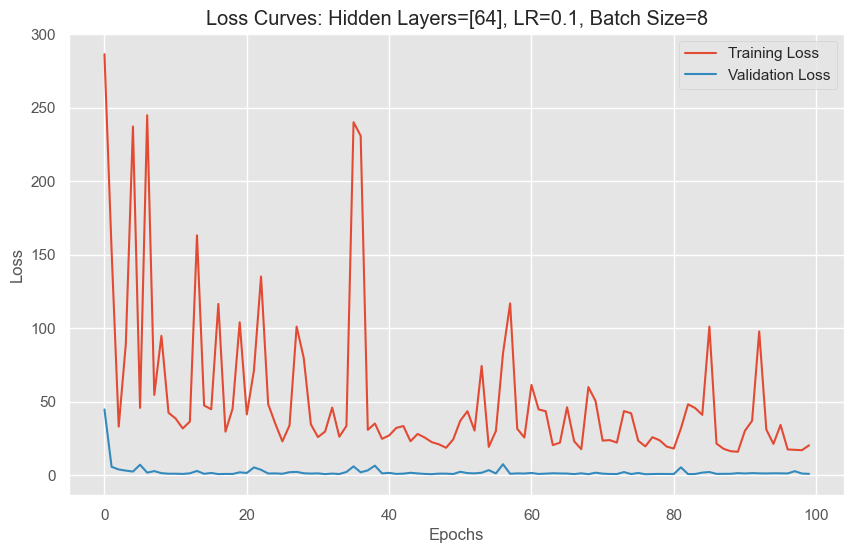

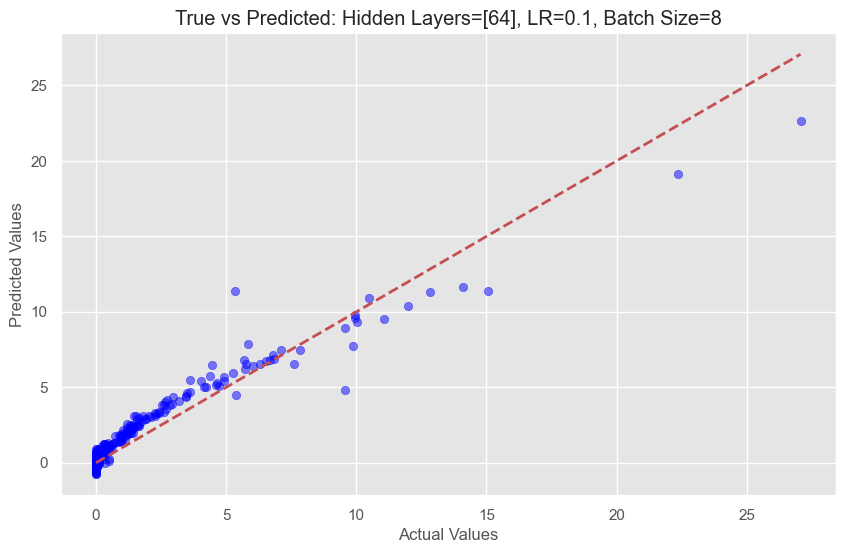


Training with hidden layers [64], learning rate 0.1 and batch size 16...

Epoch 0/100, Training Loss: 519.7734390109084, Validation Loss: 35.29085603513216
Epoch 10/100, Training Loss: 53.62934826972873, Validation Loss: 2.812673634604404
Epoch 20/100, Training Loss: 368.06209955936254, Validation Loss: 17.410183900281
Epoch 30/100, Training Loss: 66.36298349049203, Validation Loss: 5.0526464989310815
Epoch 40/100, Training Loss: 58.79097143092821, Validation Loss: 2.56135483478245
Epoch 50/100, Training Loss: 46.51351014542025, Validation Loss: 1.9900080718492206
Epoch 60/100, Training Loss: 123.60973143854807, Validation Loss: 10.488800550761976
Epoch 70/100, Training Loss: 26.561507704429502, Validation Loss: 1.1517188800008673
Epoch 80/100, Training Loss: 19.358971113035846, Validation Loss: 2.1068065982115898
Epoch 90/100, Training Loss: 29.5155678439972, Validation Loss: 1.7534855008125305
R² Score: 0.9473


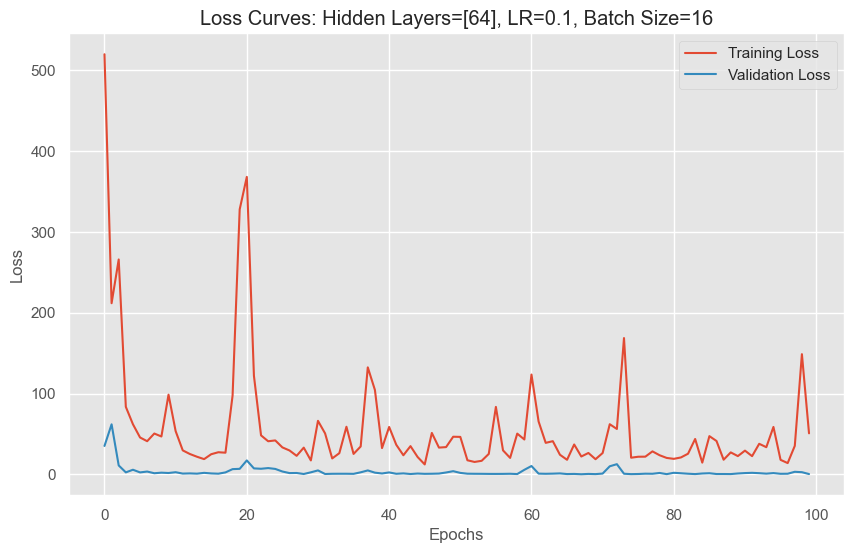

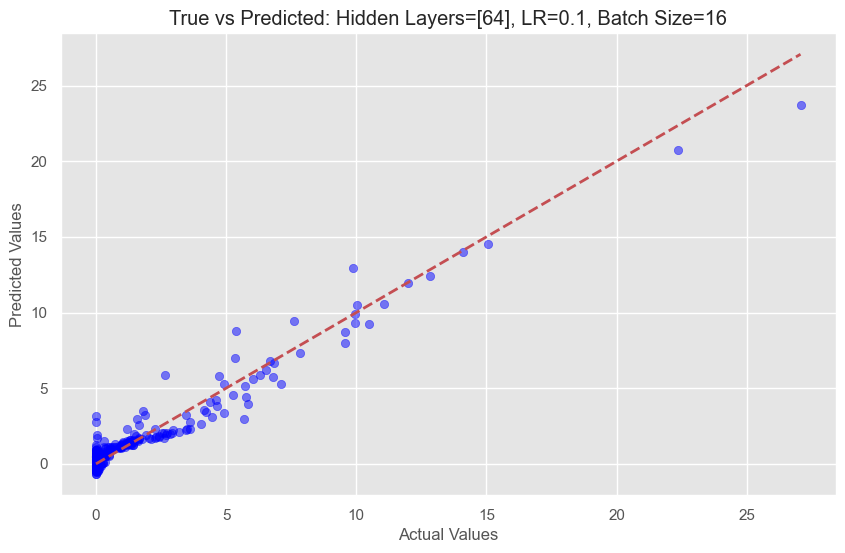


Training with hidden layers [64], learning rate 0.1 and batch size 32...

Epoch 0/100, Training Loss: 271.03039847720754, Validation Loss: 48.74501285552979
Epoch 10/100, Training Loss: 27.161076907407153, Validation Loss: 1.1783345319330691
Epoch 20/100, Training Loss: 22.83042971654372, Validation Loss: 0.8573516093194484
Epoch 30/100, Training Loss: 152.0527077533982, Validation Loss: 2.6550971925258637
Epoch 40/100, Training Loss: 12.947748917070301, Validation Loss: 0.7388268806040287
Epoch 50/100, Training Loss: 111.59152366356416, Validation Loss: 4.629842483997345
Epoch 60/100, Training Loss: 16.694857722317632, Validation Loss: 0.5607104269787669
Epoch 70/100, Training Loss: 15.530067087574439, Validation Loss: 0.27258244194090364
Epoch 80/100, Training Loss: 21.486251803961668, Validation Loss: 0.9329945527017116
Epoch 90/100, Training Loss: 25.369015433571555, Validation Loss: 1.8205148696899414
R² Score: 0.9639


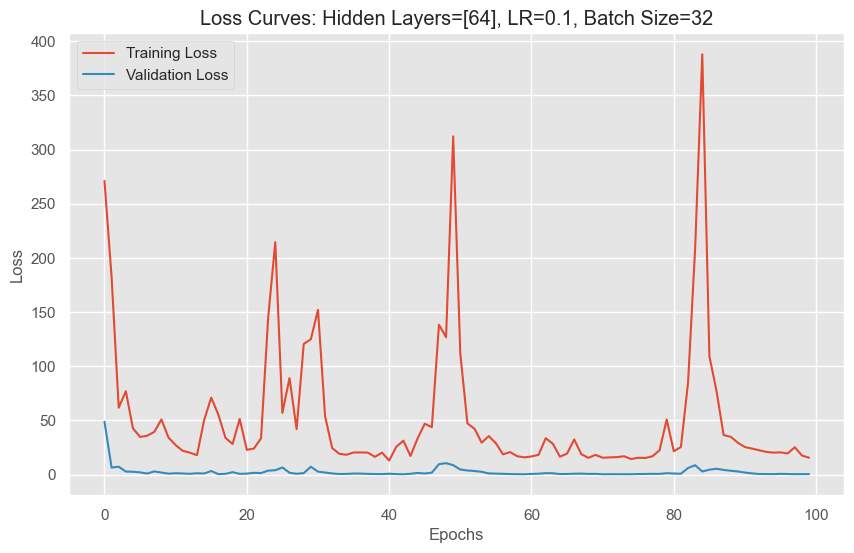

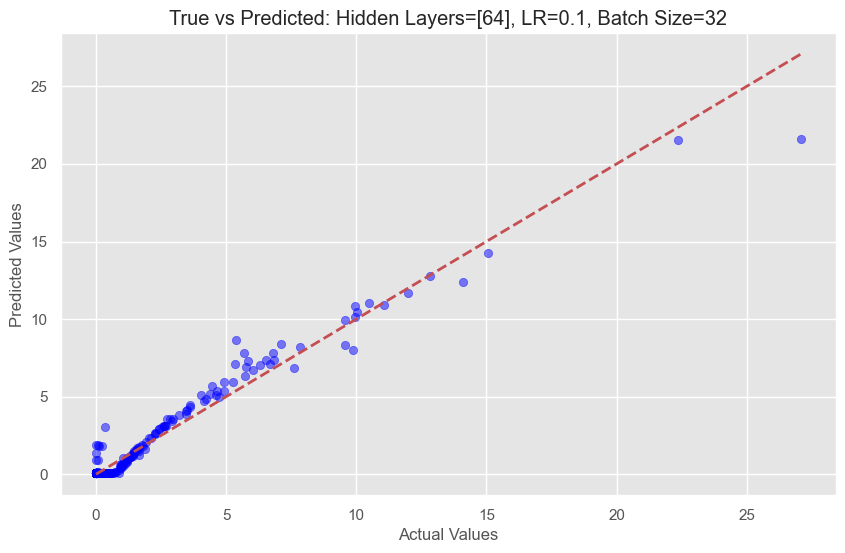


Training with hidden layers [64], learning rate 0.1 and batch size 64...

Epoch 0/100, Training Loss: 729.1567582650619, Validation Loss: 20.95783348083496
Epoch 10/100, Training Loss: 35.02895829352465, Validation Loss: 1.4362718224525453
Epoch 20/100, Training Loss: 20.642653649503533, Validation Loss: 0.4073786586523056
Epoch 30/100, Training Loss: 18.42123106663877, Validation Loss: 1.4762749910354613
Epoch 40/100, Training Loss: 14.229221148924394, Validation Loss: 1.7081226706504822
Epoch 50/100, Training Loss: 144.850835675543, Validation Loss: 2.693927264213562
Epoch 60/100, Training Loss: 9.936368693004955, Validation Loss: 2.1137664914131165
Epoch 70/100, Training Loss: 4.516134635968641, Validation Loss: 1.850550079345703
Epoch 80/100, Training Loss: 6.506790190935135, Validation Loss: 1.3925156116485595
Epoch 90/100, Training Loss: 37.71656789562919, Validation Loss: 3.0163262128829955
R² Score: 0.3023


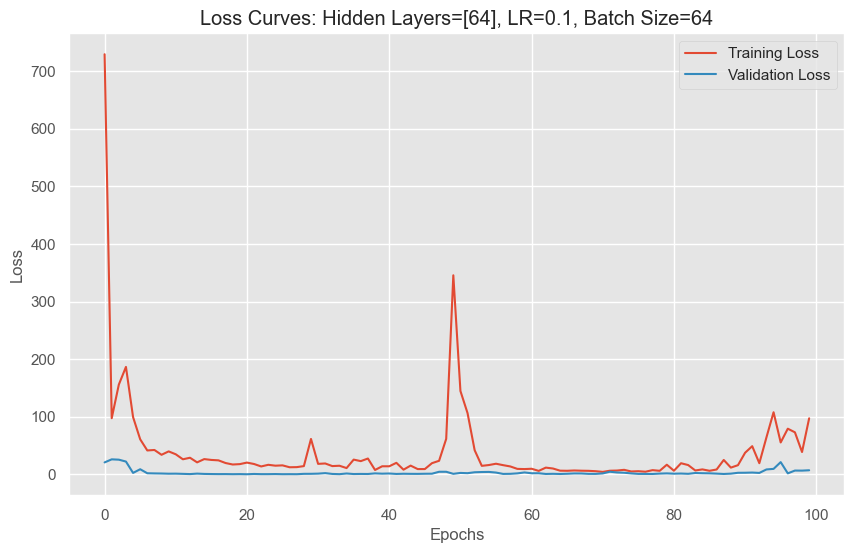

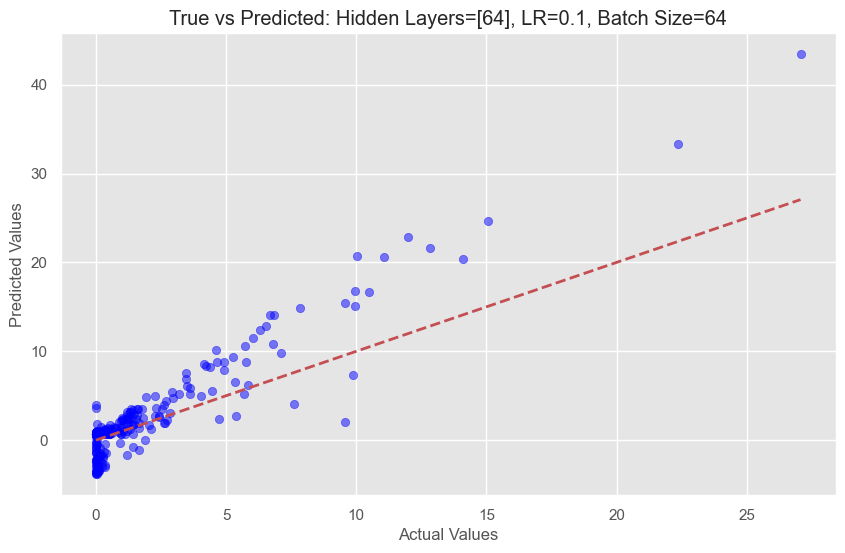


Training with hidden layers [64], learning rate 0.01 and batch size 8...

Epoch 0/100, Training Loss: 833.903676530303, Validation Loss: 2.1062886449130804
Epoch 10/100, Training Loss: 54.77577622616014, Validation Loss: 7.159720366065566
Epoch 20/100, Training Loss: 35.05500474780105, Validation Loss: 5.664659666048514
Epoch 30/100, Training Loss: 21.513074438065985, Validation Loss: 2.415573603196724
Epoch 40/100, Training Loss: 15.748564809040968, Validation Loss: 1.8704031333327293
Epoch 50/100, Training Loss: 12.586648496430973, Validation Loss: 2.779099932393512
Epoch 60/100, Training Loss: 24.14675866188698, Validation Loss: 2.893509157203339
Epoch 70/100, Training Loss: 9.694976974885131, Validation Loss: 1.9979407380561571
Epoch 80/100, Training Loss: 8.494869617182156, Validation Loss: 2.2356702427606323
Epoch 90/100, Training Loss: 10.095566321770812, Validation Loss: 1.9993628279582873
R² Score: 0.6739


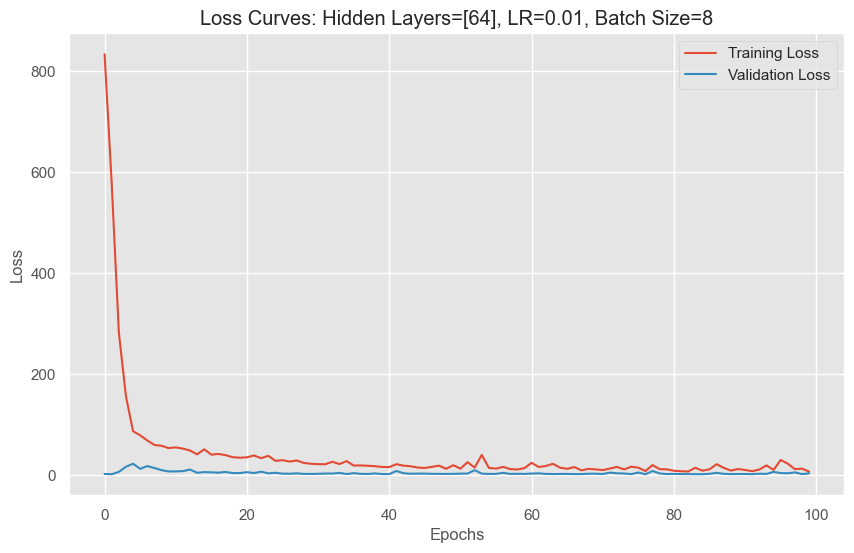

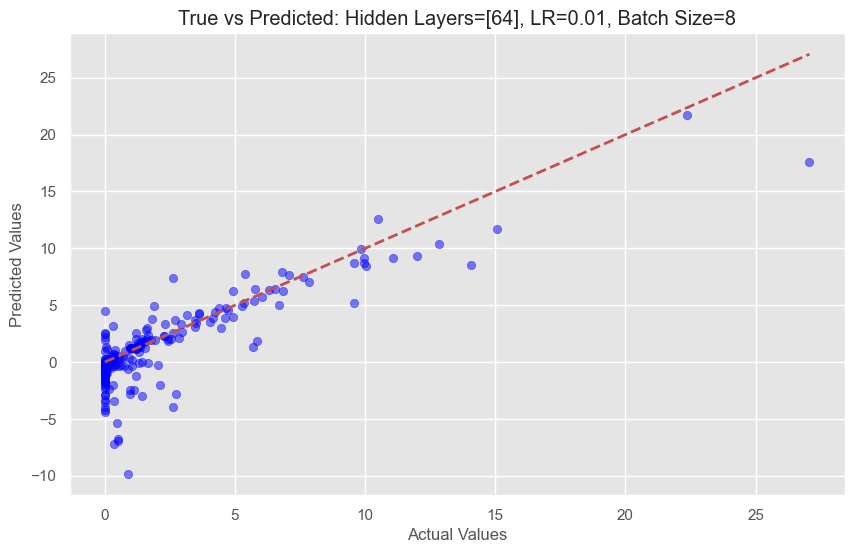


Training with hidden layers [64], learning rate 0.01 and batch size 16...

Epoch 0/100, Training Loss: 874.491767023885, Validation Loss: 7.6391921043396
Epoch 10/100, Training Loss: 54.96958851259808, Validation Loss: 8.310340166091919
Epoch 20/100, Training Loss: 30.237326234579086, Validation Loss: 2.1942596035568336
Epoch 30/100, Training Loss: 23.51183780473332, Validation Loss: 2.072516737015624
Epoch 40/100, Training Loss: 18.440518566342288, Validation Loss: 2.4683200858141245
Epoch 50/100, Training Loss: 16.647860719714053, Validation Loss: 2.3965789001238975
Epoch 60/100, Training Loss: 11.128969608351241, Validation Loss: 1.87661737674161
Epoch 70/100, Training Loss: 12.563349979561428, Validation Loss: 3.8305944204330444
Epoch 80/100, Training Loss: 7.554092787725981, Validation Loss: 1.7681795586096614
Epoch 90/100, Training Loss: 13.719578641791676, Validation Loss: 1.648612152588995
R² Score: 0.7544


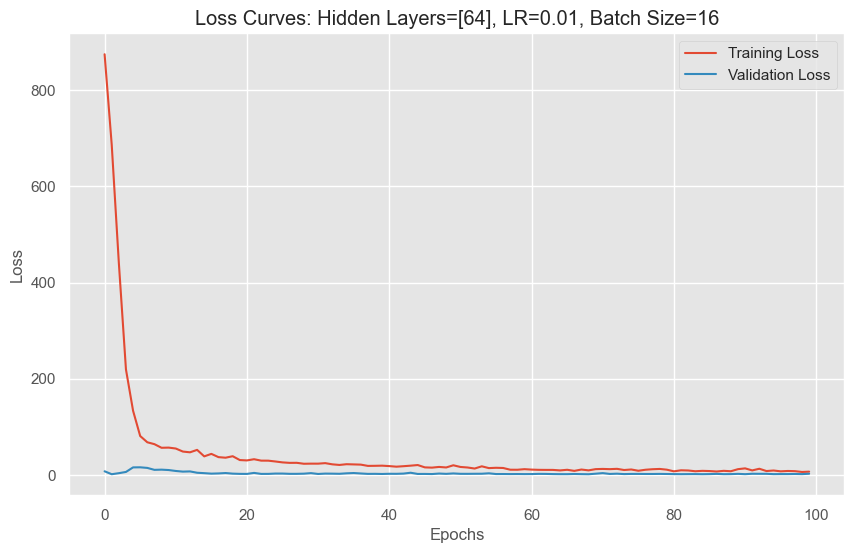

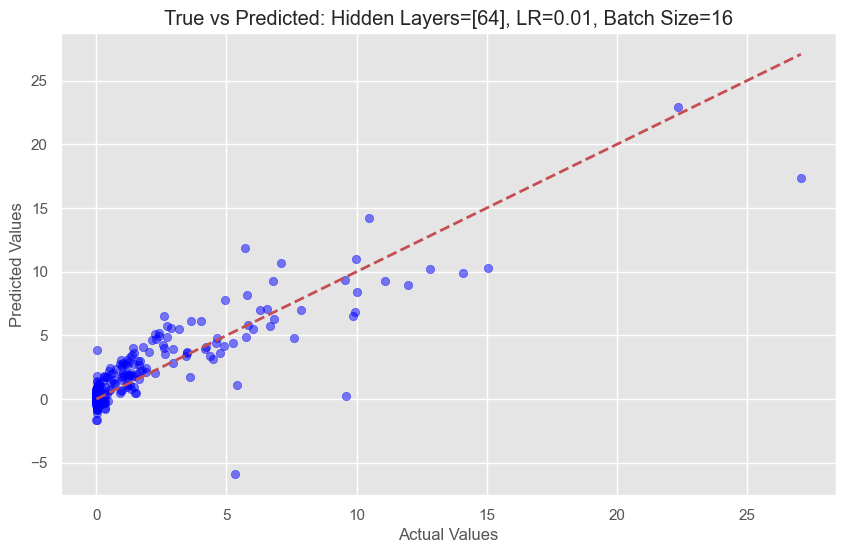


Training with hidden layers [64], learning rate 0.01 and batch size 32...

Epoch 0/100, Training Loss: 933.5140429951928, Validation Loss: 8.65178965330124
Epoch 10/100, Training Loss: 70.14377424933694, Validation Loss: 16.085616135597228
Epoch 20/100, Training Loss: 35.578424261374906, Validation Loss: 3.9792250037193297
Epoch 30/100, Training Loss: 33.594310543753885, Validation Loss: 3.778096914291382
Epoch 40/100, Training Loss: 23.594488496130165, Validation Loss: 2.9497730523347854
Epoch 50/100, Training Loss: 19.53984770449725, Validation Loss: 2.9223318129777907
Epoch 60/100, Training Loss: 17.551351736892354, Validation Loss: 3.1789928674697876
Epoch 70/100, Training Loss: 14.118106007575989, Validation Loss: 2.727552145719528
Epoch 80/100, Training Loss: 13.078133523464203, Validation Loss: 2.996552276611328
Epoch 90/100, Training Loss: 11.18717702681368, Validation Loss: 3.1726251602172852
R² Score: 0.8015


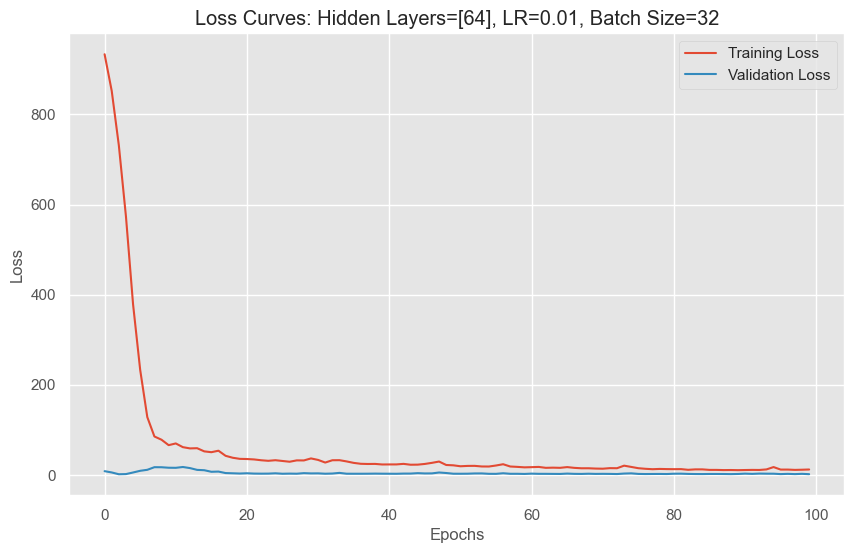

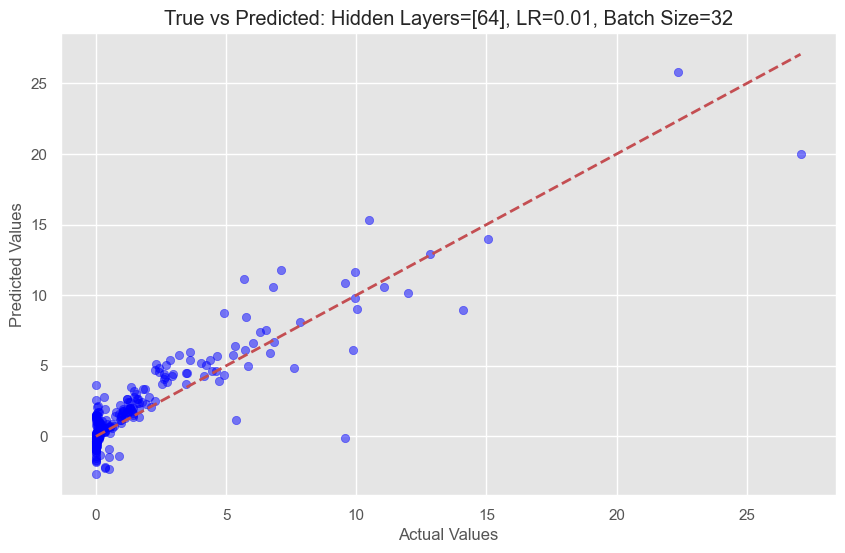


Training with hidden layers [64], learning rate 0.01 and batch size 64...

Epoch 0/100, Training Loss: 968.7057091973045, Validation Loss: 10.66264729499817
Epoch 10/100, Training Loss: 143.69573974609375, Validation Loss: 14.437261772155761
Epoch 20/100, Training Loss: 50.04553239995783, Validation Loss: 10.943260002136231
Epoch 30/100, Training Loss: 35.77090545134111, Validation Loss: 4.115924263000489
Epoch 40/100, Training Loss: 27.935607281598177, Validation Loss: 3.178659963607788
Epoch 50/100, Training Loss: 24.023821061307732, Validation Loss: 2.9825533628463745
Epoch 60/100, Training Loss: 21.955037810585715, Validation Loss: 2.842613959312439
Epoch 70/100, Training Loss: 19.04753214662725, Validation Loss: 2.828110456466675
Epoch 80/100, Training Loss: 17.05349815975536, Validation Loss: 2.5703402042388914
Epoch 90/100, Training Loss: 14.422716324979609, Validation Loss: 2.4831520318984985
R² Score: 0.7866


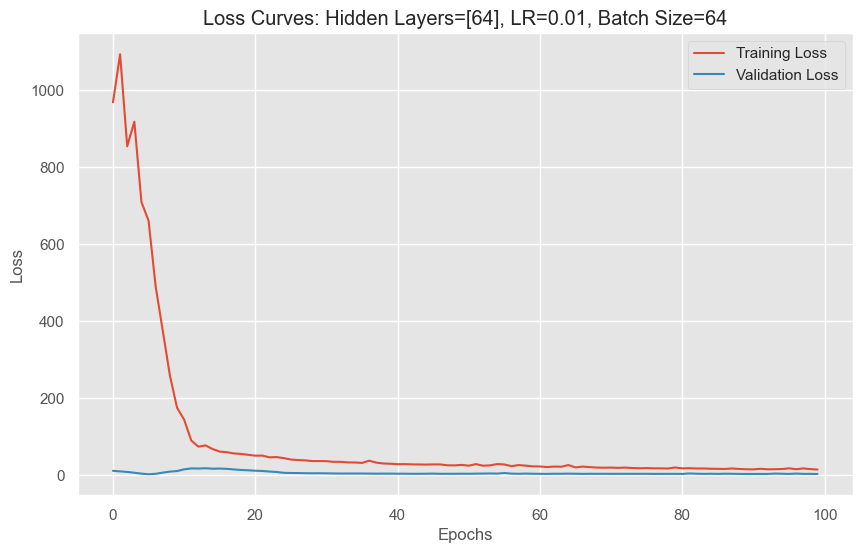

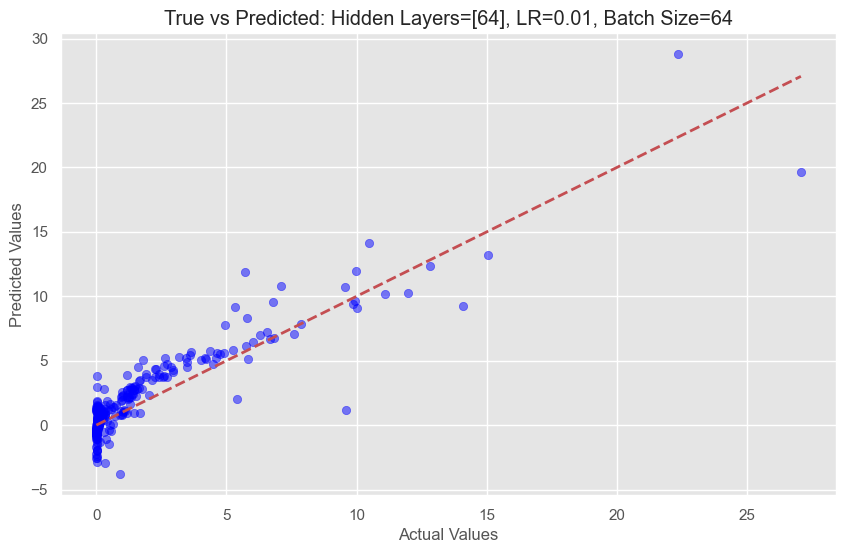


Training with hidden layers [64], learning rate 0.001 and batch size 8...

Epoch 0/100, Training Loss: 984.9714016638003, Validation Loss: 11.107152343601793
Epoch 10/100, Training Loss: 739.8557508243898, Validation Loss: 1.9216999814317033
Epoch 20/100, Training Loss: 370.08686988055706, Validation Loss: 2.786206309859817
Epoch 30/100, Training Loss: 152.41954968696416, Validation Loss: 9.041583979451978
Epoch 40/100, Training Loss: 80.4410469254782, Validation Loss: 14.76678974564011
Epoch 50/100, Training Loss: 62.153924998848936, Validation Loss: 14.523359801318195
Epoch 60/100, Training Loss: 48.755325453919035, Validation Loss: 6.936967840065828
Epoch 70/100, Training Loss: 40.484435957531595, Validation Loss: 3.4283581090134545
Epoch 80/100, Training Loss: 35.88541646873535, Validation Loss: 2.3821056759035266
Epoch 90/100, Training Loss: 33.24824552896411, Validation Loss: 2.184785583132022
R² Score: 0.7994


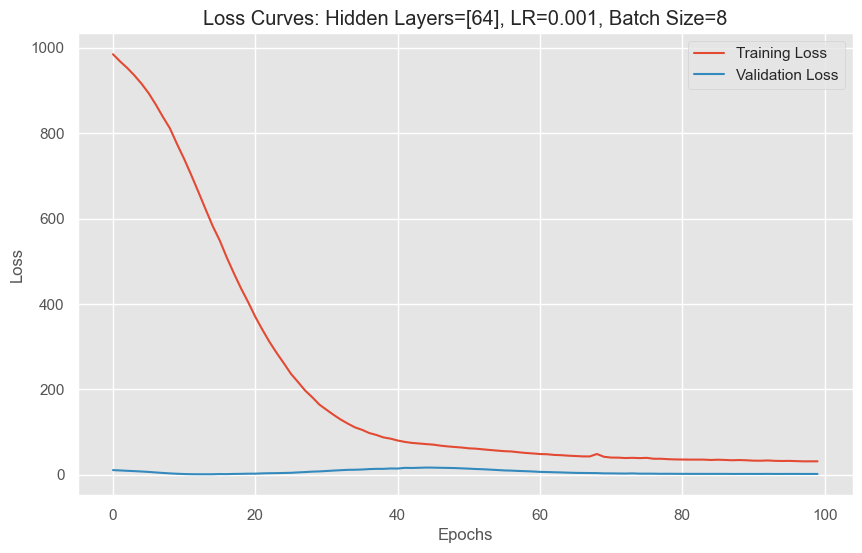

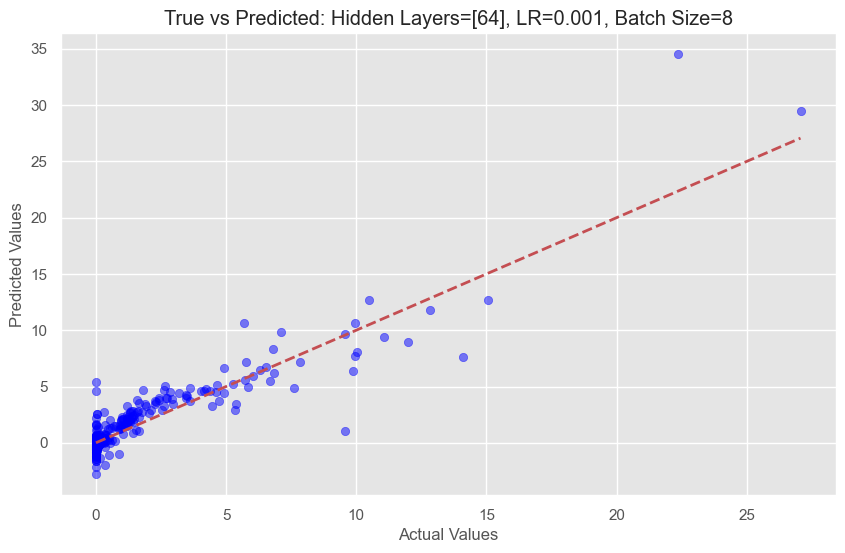


Training with hidden layers [64], learning rate 0.001 and batch size 16...

Epoch 0/100, Training Loss: 980.9047686887342, Validation Loss: 11.399521574378014
Epoch 10/100, Training Loss: 833.4198650357336, Validation Loss: 5.145301791398149
Epoch 20/100, Training Loss: 569.2415321081183, Validation Loss: 1.3009081890708523
Epoch 30/100, Training Loss: 320.12006392312605, Validation Loss: 2.828041911125183
Epoch 40/100, Training Loss: 162.46531769841215, Validation Loss: 7.7094223122847705
Epoch 50/100, Training Loss: 92.90820955675701, Validation Loss: 12.436924281873202
Epoch 60/100, Training Loss: 67.91320857336355, Validation Loss: 15.320365855568333
Epoch 70/100, Training Loss: 60.26037853817607, Validation Loss: 15.502468862031636
Epoch 80/100, Training Loss: 56.499225483384244, Validation Loss: 14.776880866602847
Epoch 90/100, Training Loss: 52.877263645793114, Validation Loss: 13.1787926523309
R² Score: -0.1939


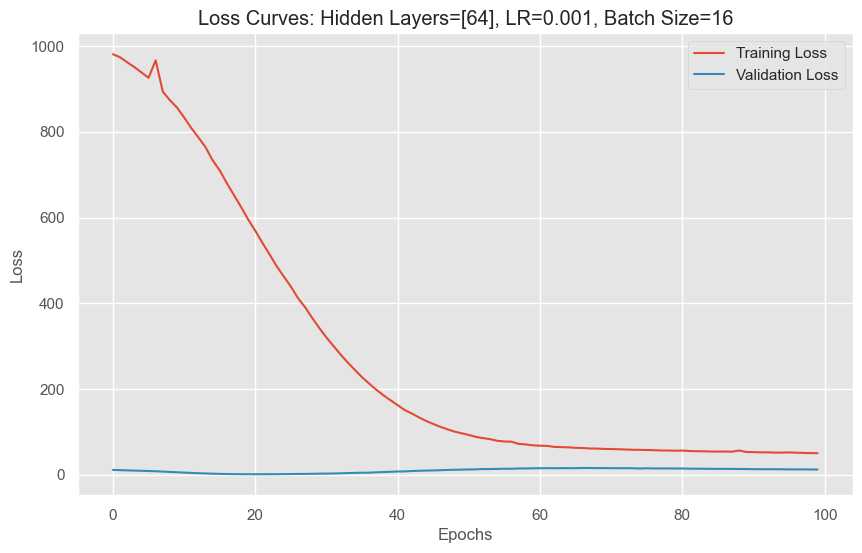

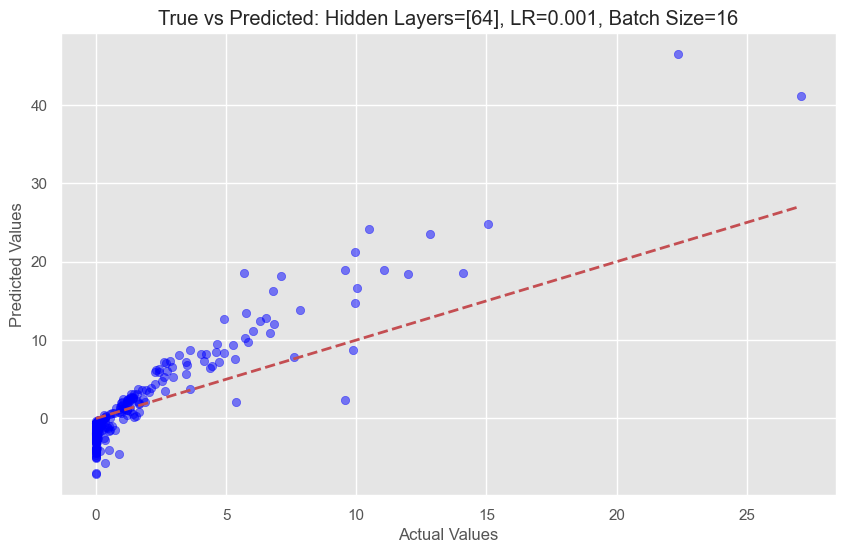


Training with hidden layers [64], learning rate 0.001 and batch size 32...

Epoch 0/100, Training Loss: 965.650741869753, Validation Loss: 10.510079799592495
Epoch 10/100, Training Loss: 875.1208081164143, Validation Loss: 6.425267577171326
Epoch 20/100, Training Loss: 735.8023484647274, Validation Loss: 2.1884766474366186
Epoch 30/100, Training Loss: 554.3795343678106, Validation Loss: 1.5394648253917693
Epoch 40/100, Training Loss: 384.3727249828252, Validation Loss: 2.3271834373474123
Epoch 50/100, Training Loss: 248.6249992088838, Validation Loss: 4.206248486042023
Epoch 60/100, Training Loss: 162.28908412023023, Validation Loss: 7.41880624294281
Epoch 70/100, Training Loss: 110.19929712468928, Validation Loss: 10.68795120716095
Epoch 80/100, Training Loss: 82.87720743092623, Validation Loss: 13.101389312744141
Epoch 90/100, Training Loss: 70.17892555757003, Validation Loss: 15.212842988967896
R² Score: -0.4786


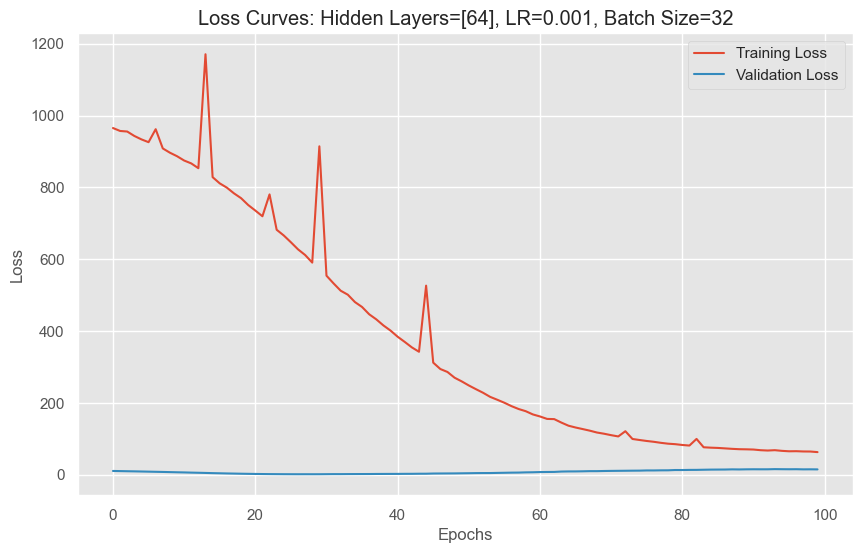

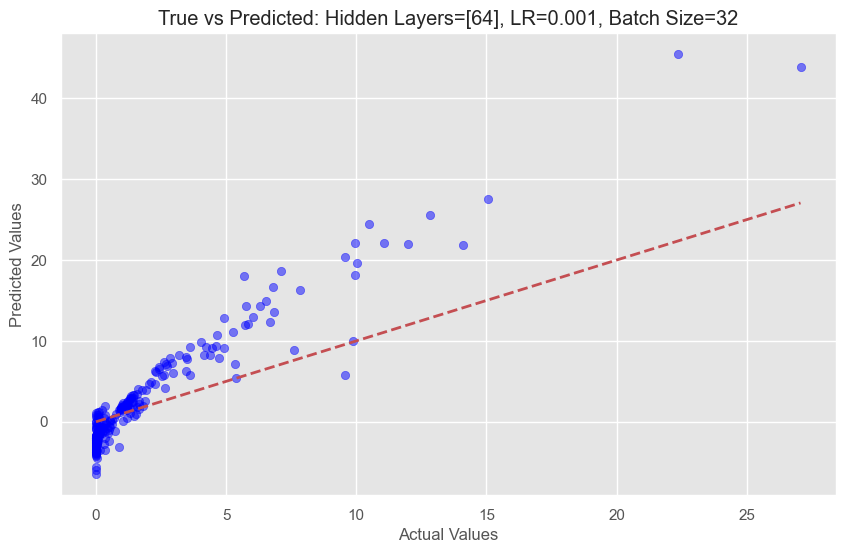


Training with hidden layers [64], learning rate 0.001 and batch size 64...

Epoch 0/100, Training Loss: 973.2568410526623, Validation Loss: 12.58380060195923
Epoch 10/100, Training Loss: 932.7263061783531, Validation Loss: 9.818065977096557
Epoch 20/100, Training Loss: 844.6853724392978, Validation Loss: 7.454107093811035
Epoch 30/100, Training Loss: 739.910408821973, Validation Loss: 4.387062644958496
Epoch 40/100, Training Loss: 607.67796273665, Validation Loss: 2.0607622623443604
Epoch 50/100, Training Loss: 471.6644521193071, Validation Loss: 2.173781728744507
Epoch 60/100, Training Loss: 365.99526955864644, Validation Loss: 3.172396993637085
Epoch 70/100, Training Loss: 257.3483818661083, Validation Loss: 4.614354991912842
Epoch 80/100, Training Loss: 185.61183751713145, Validation Loss: 6.6319272994995115
Epoch 90/100, Training Loss: 136.39207016338003, Validation Loss: 9.619670867919922
R² Score: -0.0856


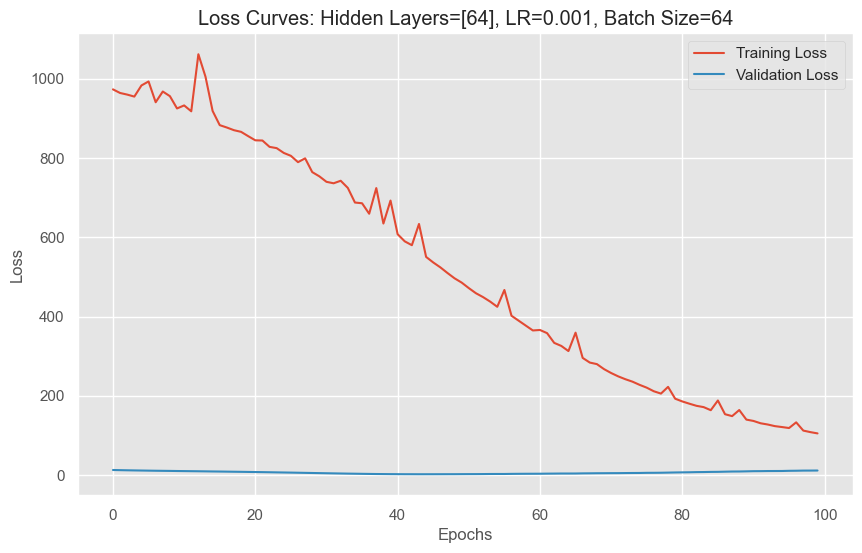

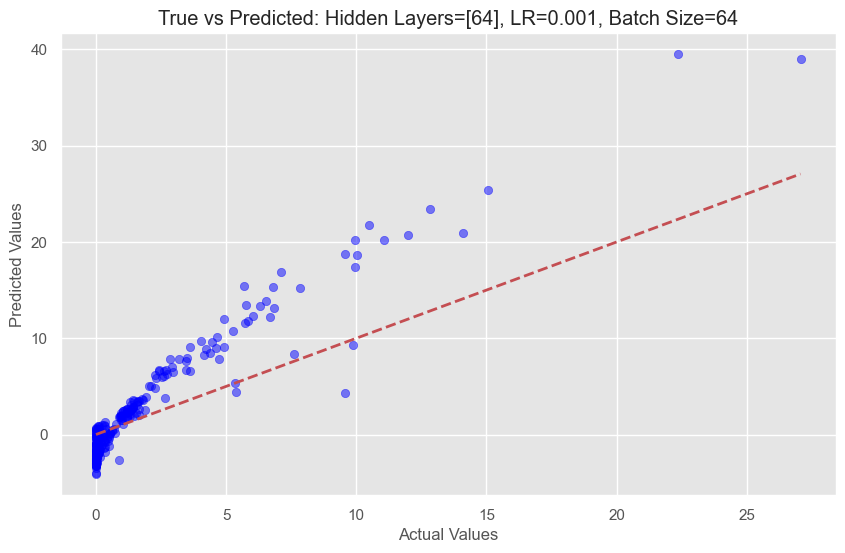


Training with hidden layers [128, 64], learning rate 0.1 and batch size 8...

Epoch 0/100, Training Loss: 790.2474301505055, Validation Loss: 14.666921896608295
Epoch 10/100, Training Loss: 981.9215048523837, Validation Loss: 18.402863554052406
Epoch 20/100, Training Loss: 981.206766594288, Validation Loss: 20.685787381352604
Epoch 30/100, Training Loss: 981.0972686035689, Validation Loss: 19.09384418178249
Epoch 40/100, Training Loss: 982.3566960179528, Validation Loss: 18.325350606763685
Epoch 50/100, Training Loss: 981.3089867303538, Validation Loss: 18.877750577153385
Epoch 60/100, Training Loss: 980.9762643437053, Validation Loss: 18.625528284021325
Epoch 70/100, Training Loss: 981.3524912568026, Validation Loss: 18.334552661792653
Epoch 80/100, Training Loss: 981.5880434124969, Validation Loss: 19.59331721228522
Epoch 90/100, Training Loss: 981.2856998000034, Validation Loss: 19.38734113847887
R² Score: -0.8474


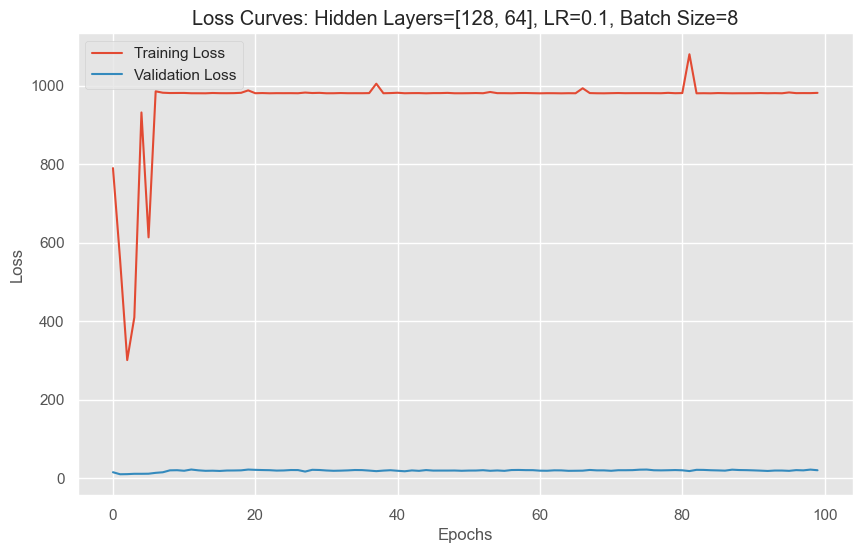

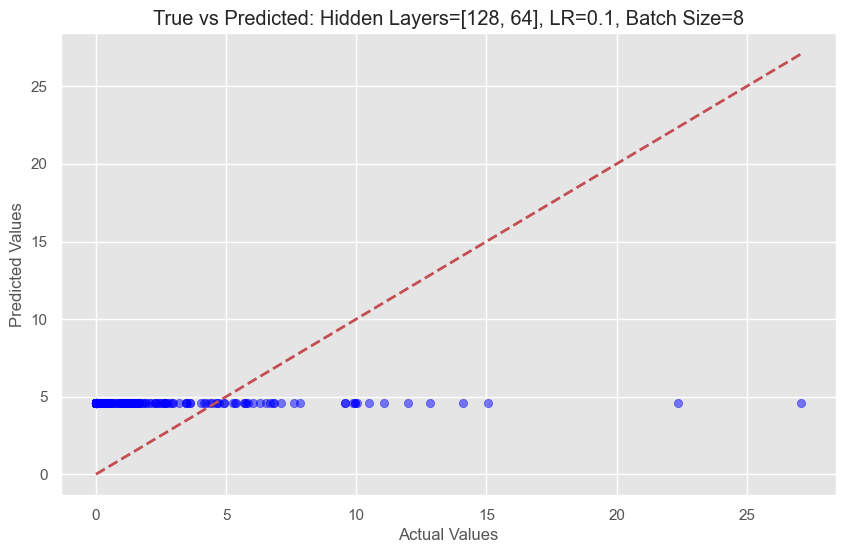


Training with hidden layers [128, 64], learning rate 0.1 and batch size 16...

Epoch 0/100, Training Loss: 2237.0438107085783, Validation Loss: 12.03950081373516
Epoch 10/100, Training Loss: 12.460047677505848, Validation Loss: 9.174151608818455
Epoch 20/100, Training Loss: 50.160401549450185, Validation Loss: 10.382915816809001
Epoch 30/100, Training Loss: 10.116469824036887, Validation Loss: 5.392596815761767
Epoch 40/100, Training Loss: 20.304244437883067, Validation Loss: 8.254252929436532
Epoch 50/100, Training Loss: 22.94146129974099, Validation Loss: 7.504412111483123
Epoch 60/100, Training Loss: 39.553778547187186, Validation Loss: 7.006181647903041
Epoch 70/100, Training Loss: 22.407942282599073, Validation Loss: 5.932966276219017
Epoch 80/100, Training Loss: 982.8835557449696, Validation Loss: 16.943315606368216
Epoch 90/100, Training Loss: 980.87172867531, Validation Loss: 19.522846623470908
R² Score: -0.7000


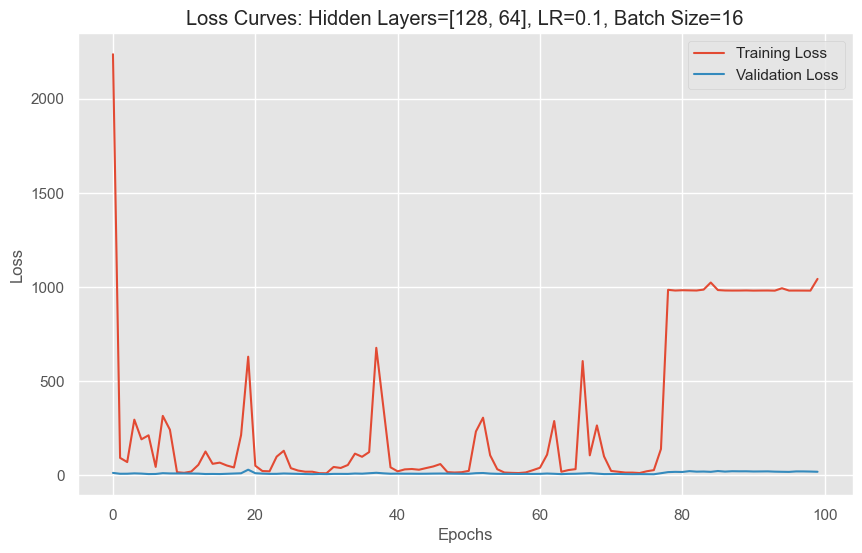

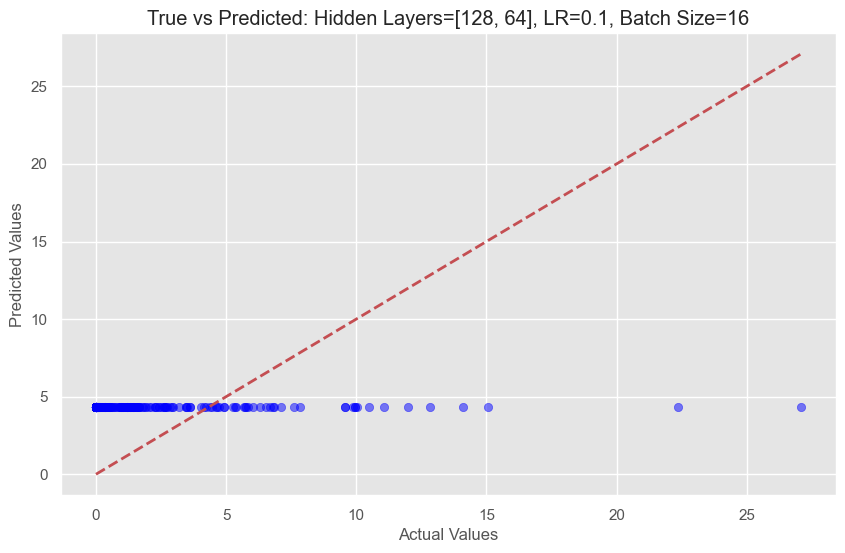


Training with hidden layers [128, 64], learning rate 0.1 and batch size 32...

Epoch 0/100, Training Loss: 1082.3854607452047, Validation Loss: 47.216692733764646
Epoch 10/100, Training Loss: 34.940593697808005, Validation Loss: 9.345407438278198
Epoch 20/100, Training Loss: 95.56083768606186, Validation Loss: 5.63257349729538
Epoch 30/100, Training Loss: 115.64441562511705, Validation Loss: 4.74965580701828
Epoch 40/100, Training Loss: 56.1476359909231, Validation Loss: 4.450252485275269
Epoch 50/100, Training Loss: 12.951376327059485, Validation Loss: 4.332006910443306
Epoch 60/100, Training Loss: 57.29749635132876, Validation Loss: 8.03083508014679
Epoch 70/100, Training Loss: 50.057871561158784, Validation Loss: 3.0616157565265896
Epoch 80/100, Training Loss: 14.629185373132879, Validation Loss: 5.840770488977432
Epoch 90/100, Training Loss: 8.19356420365247, Validation Loss: 4.572303906083107
R² Score: 0.4648


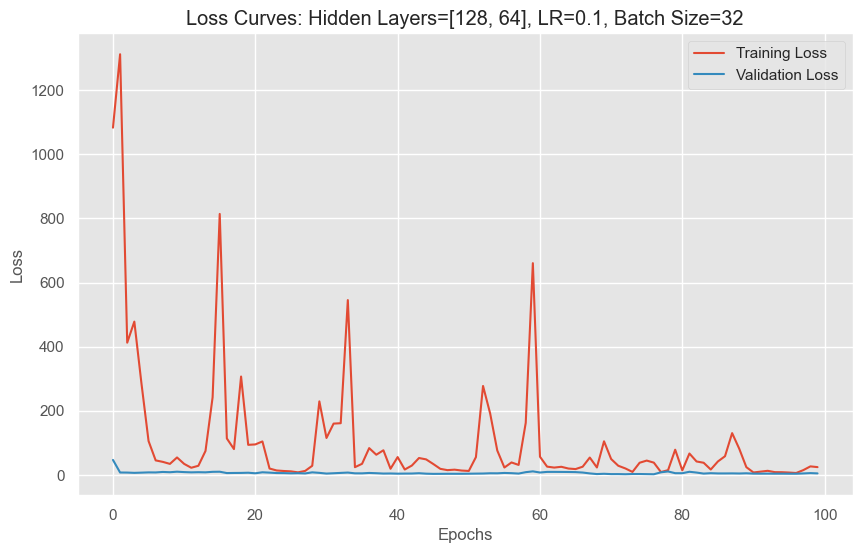

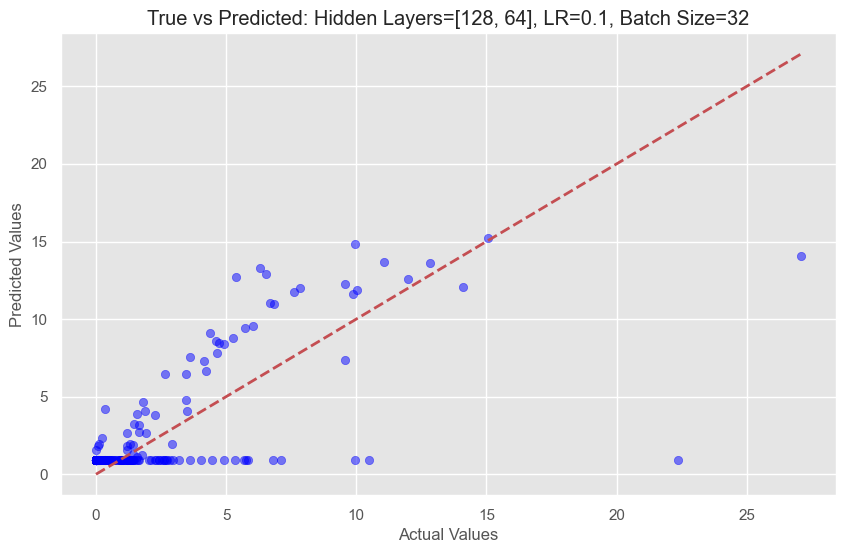


Training with hidden layers [128, 64], learning rate 0.1 and batch size 64...

Epoch 0/100, Training Loss: 1036.7611014842987, Validation Loss: 9.710223770141601
Epoch 10/100, Training Loss: 65.88881460103121, Validation Loss: 1.873887264728546
Epoch 20/100, Training Loss: 36.478807443922214, Validation Loss: 4.1959098219871525
Epoch 30/100, Training Loss: 72.81322142210874, Validation Loss: 7.757289218902588
Epoch 40/100, Training Loss: 47.12040838328275, Validation Loss: 3.5796444177627564
Epoch 50/100, Training Loss: 3.044503856788982, Validation Loss: 1.8729437828063964
Epoch 60/100, Training Loss: 1.8137909065593372, Validation Loss: 1.4673211693763732
Epoch 70/100, Training Loss: 3.141912880268964, Validation Loss: 0.9906579971313476
Epoch 80/100, Training Loss: 3.3808226747946306, Validation Loss: 0.9430283725261688
Epoch 90/100, Training Loss: 1.4242683080109684, Validation Loss: 1.229872751235962
R² Score: 0.9203


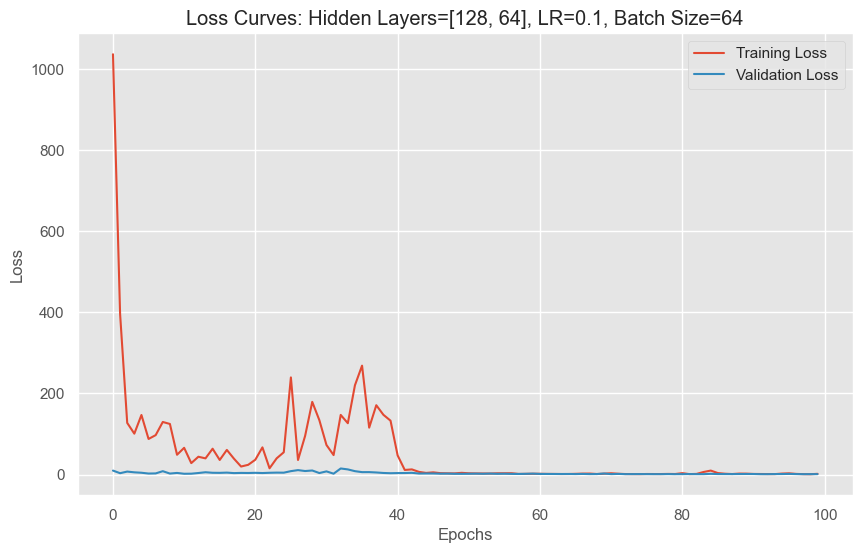

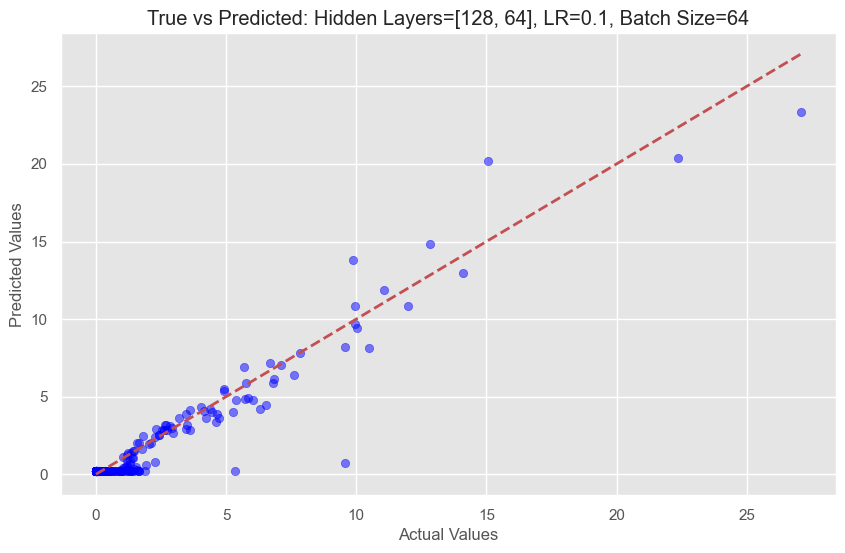


Training with hidden layers [128, 64], learning rate 0.01 and batch size 8...

Epoch 0/100, Training Loss: 709.4513772784645, Validation Loss: 1.7290962370666298
Epoch 10/100, Training Loss: 138.05677627510022, Validation Loss: 1.914311478266845
Epoch 20/100, Training Loss: 59.7129651871185, Validation Loss: 1.802819100082726
Epoch 30/100, Training Loss: 33.511834758160596, Validation Loss: 1.5376544534606305
Epoch 40/100, Training Loss: 3.0476019933473233, Validation Loss: 1.5963555735510748
Epoch 50/100, Training Loss: 28.51853104854046, Validation Loss: 1.3582021667546518
Epoch 60/100, Training Loss: 4.101508629963148, Validation Loss: 1.053709965199232
Epoch 70/100, Training Loss: 77.26022898483761, Validation Loss: 2.5428284877860867
Epoch 80/100, Training Loss: 2.285807106860502, Validation Loss: 0.7215199943732571
Epoch 90/100, Training Loss: 8.033088246143835, Validation Loss: 1.149551269673818
R² Score: 0.8803


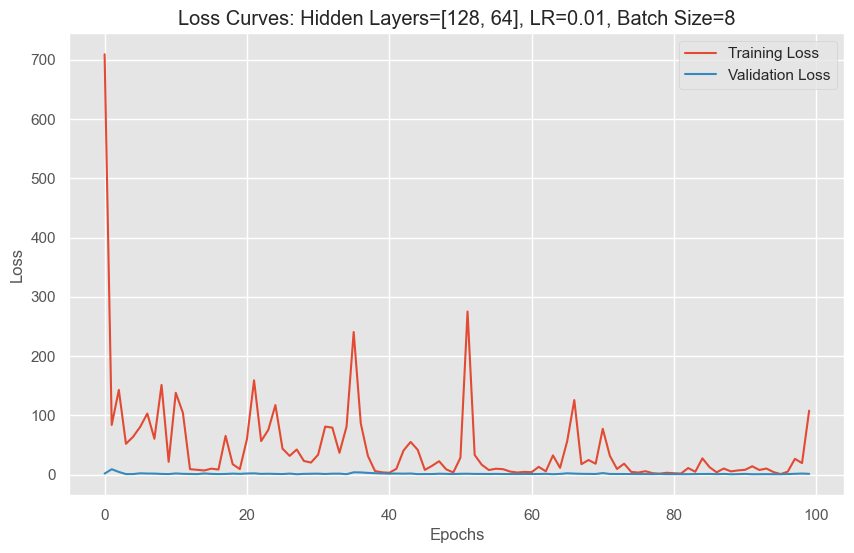

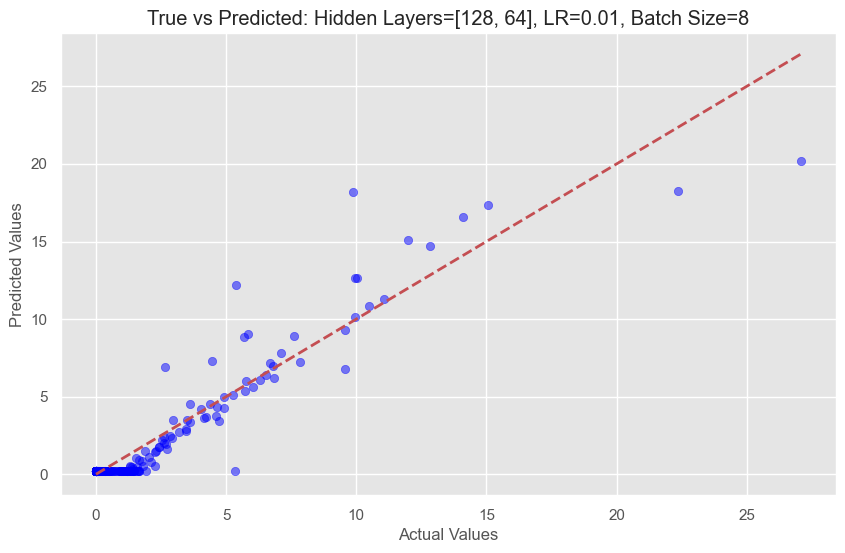


Training with hidden layers [128, 64], learning rate 0.01 and batch size 16...

Epoch 0/100, Training Loss: 652.6891197922617, Validation Loss: 7.971221402287483
Epoch 10/100, Training Loss: 96.04926071957101, Validation Loss: 2.0782890437464965
Epoch 20/100, Training Loss: 151.376612730151, Validation Loss: 0.9696880767219945
Epoch 30/100, Training Loss: 7.8055552641839485, Validation Loss: 0.40904732401433747
Epoch 40/100, Training Loss: 3.8830954683727996, Validation Loss: 0.4996153053484465
Epoch 50/100, Training Loss: 119.51124556713499, Validation Loss: 3.069276850474508
Epoch 60/100, Training Loss: 5.497676520153534, Validation Loss: 0.7323277341692072
Epoch 70/100, Training Loss: 3.1591386937124786, Validation Loss: 0.8276946258388067
Epoch 80/100, Training Loss: 1.6033462008764578, Validation Loss: 0.6520217670813987
Epoch 90/100, Training Loss: 3.0816709440807966, Validation Loss: 0.6194260990933368
R² Score: 0.9025


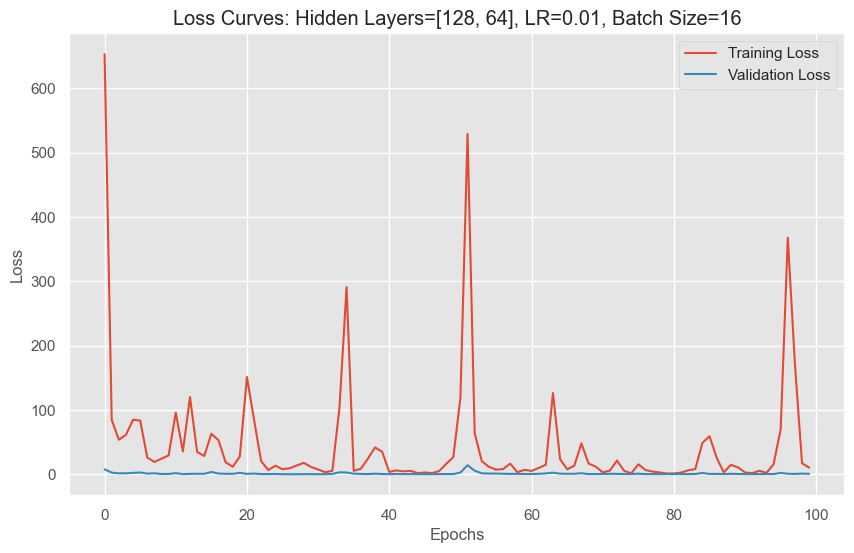

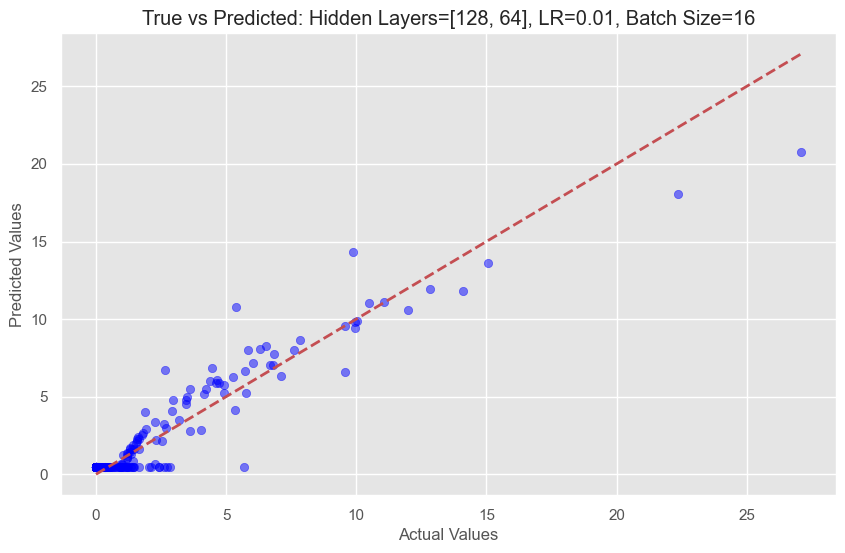


Training with hidden layers [128, 64], learning rate 0.01 and batch size 32...

Epoch 0/100, Training Loss: 585.146827313033, Validation Loss: 6.994331622123719
Epoch 10/100, Training Loss: 14.114980374886231, Validation Loss: 1.0269771048799157
Epoch 20/100, Training Loss: 17.967366653409872, Validation Loss: 1.365961603820324
Epoch 30/100, Training Loss: 14.532163125547497, Validation Loss: 1.3669651305302977
Epoch 40/100, Training Loss: 22.400639779188417, Validation Loss: 1.1498597126454115
Epoch 50/100, Training Loss: 7.879511932080442, Validation Loss: 0.7200245955958963
Epoch 60/100, Training Loss: 8.674775279381059, Validation Loss: 0.7128497175872326
Epoch 70/100, Training Loss: 4.530821191316301, Validation Loss: 0.6307727024890483
Epoch 80/100, Training Loss: 1.155357134274461, Validation Loss: 0.6378429499454796
Epoch 90/100, Training Loss: 3.492104513316669, Validation Loss: 0.5291384471580386
R² Score: 0.9476


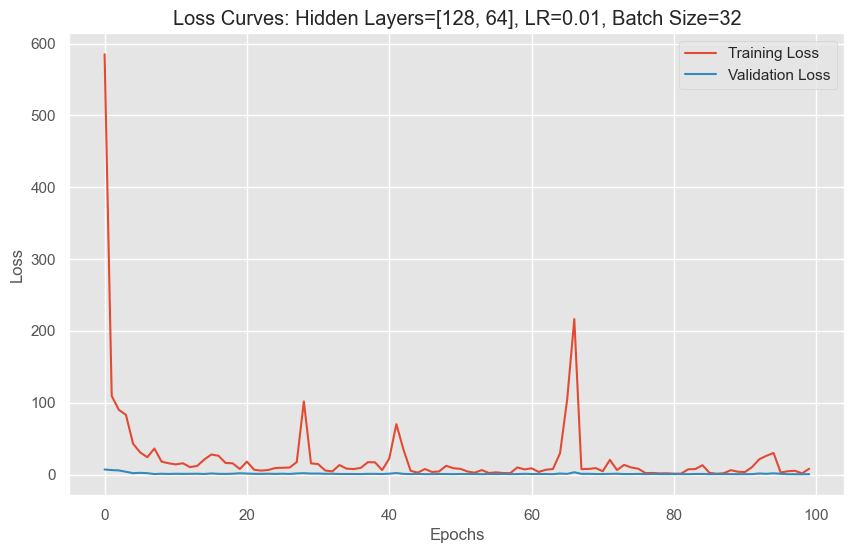

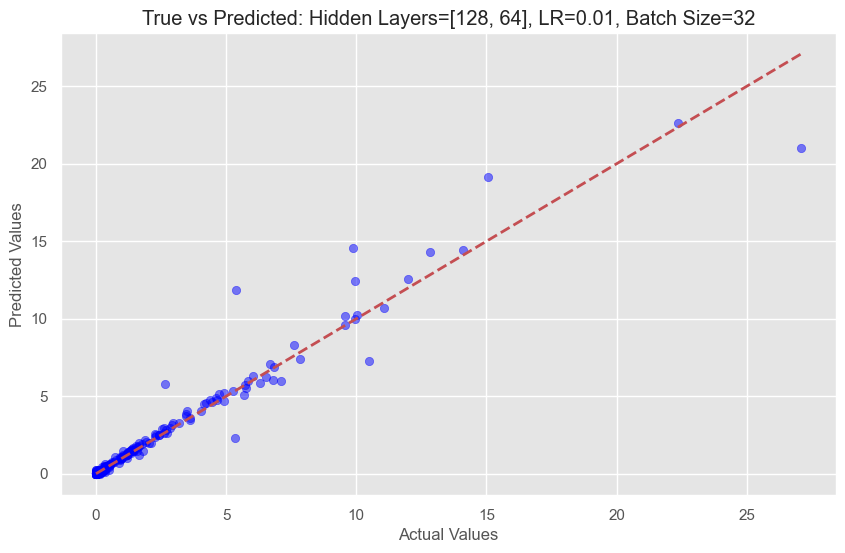


Training with hidden layers [128, 64], learning rate 0.01 and batch size 64...

Epoch 0/100, Training Loss: 894.2089956890453, Validation Loss: 5.897895050048828
Epoch 10/100, Training Loss: 52.7804144079035, Validation Loss: 5.063519287109375
Epoch 20/100, Training Loss: 13.159361389550297, Validation Loss: 1.5508516788482667
Epoch 30/100, Training Loss: 118.00501124696298, Validation Loss: 0.7534993410110473
Epoch 40/100, Training Loss: 4.75341522693634, Validation Loss: 0.8157249301671982
Epoch 50/100, Training Loss: 2.935848664153706, Validation Loss: 0.5658503413200379
Epoch 60/100, Training Loss: 1.407871430570429, Validation Loss: 0.38650056421756745
Epoch 70/100, Training Loss: 216.4313050345941, Validation Loss: 4.632769775390625
Epoch 80/100, Training Loss: 2.01149200851267, Validation Loss: 0.5305908098816872
Epoch 90/100, Training Loss: 0.9279081689363177, Validation Loss: 0.5215096771717072
R² Score: 0.9569


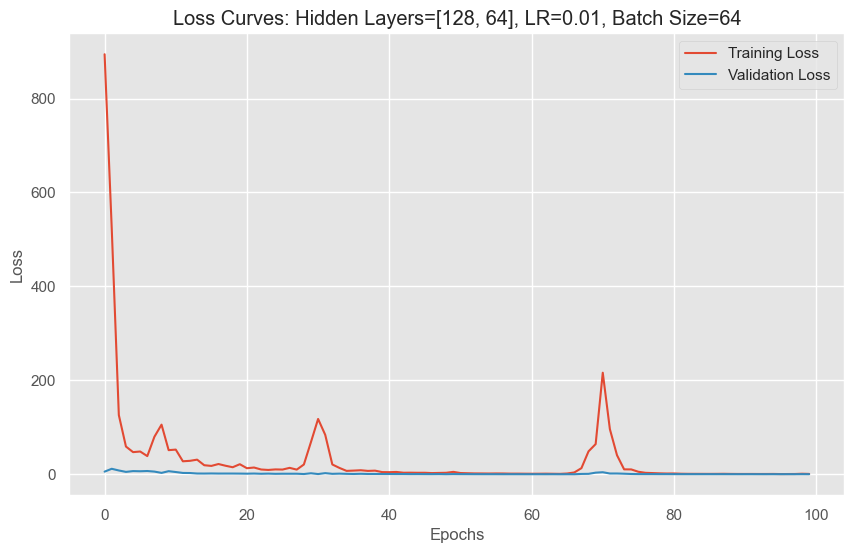

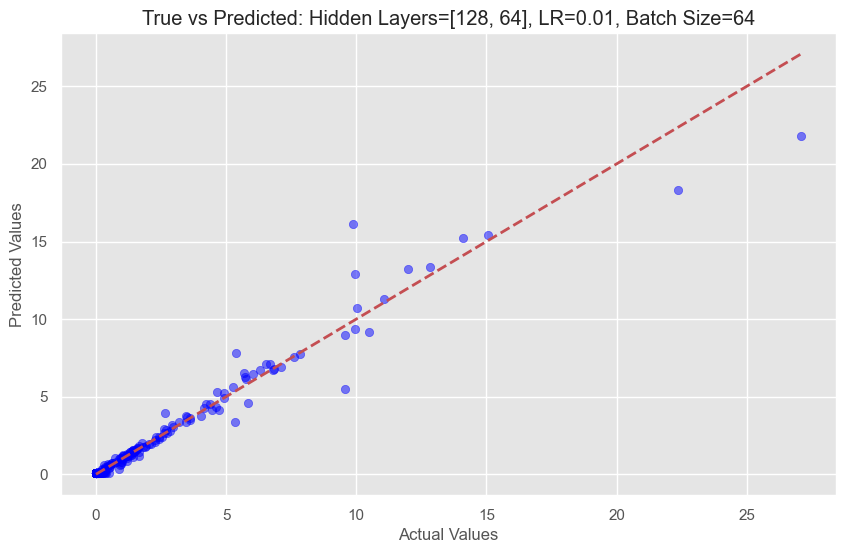


Training with hidden layers [128, 64], learning rate 0.001 and batch size 8...

Epoch 0/100, Training Loss: 985.2746538362185, Validation Loss: 9.480753065766516
Epoch 10/100, Training Loss: 49.37602725313153, Validation Loss: 2.021315074450261
Epoch 20/100, Training Loss: 27.831195092478463, Validation Loss: 1.1047995299906344
Epoch 30/100, Training Loss: 18.43636247992169, Validation Loss: 1.2578143417029768
Epoch 40/100, Training Loss: 13.324298297596533, Validation Loss: 1.406056056554253
Epoch 50/100, Training Loss: 11.682917665343645, Validation Loss: 1.3227691959489036
Epoch 60/100, Training Loss: 8.627497005731215, Validation Loss: 1.5434716843269967
Epoch 70/100, Training Loss: 10.233908640177445, Validation Loss: 1.624920092523098
Epoch 80/100, Training Loss: 6.793881643823413, Validation Loss: 1.8934068140145894
Epoch 90/100, Training Loss: 4.882138733427192, Validation Loss: 1.2966309354917422
R² Score: 0.8677


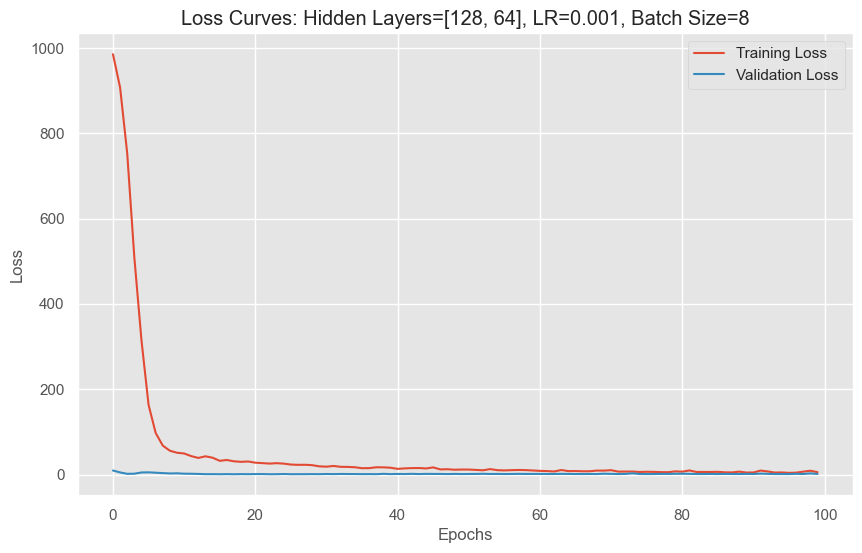

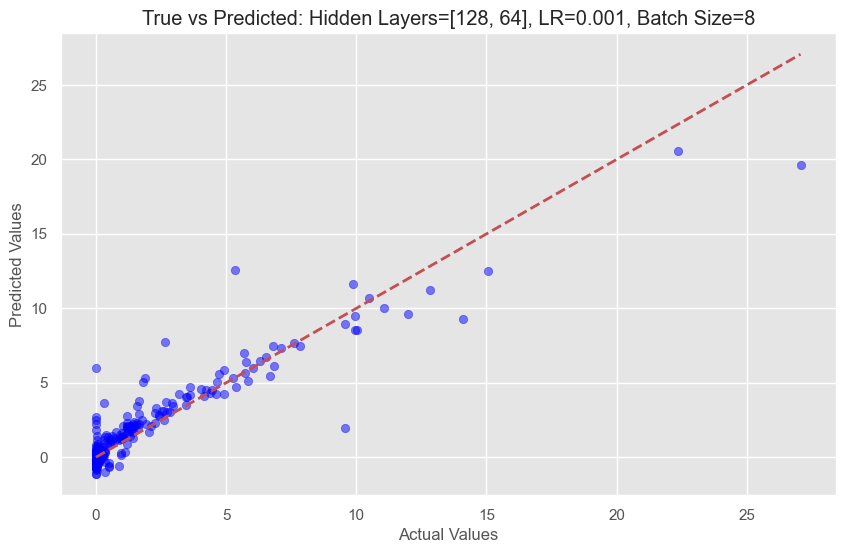


Training with hidden layers [128, 64], learning rate 0.001 and batch size 16...

Epoch 0/100, Training Loss: 993.8160913461862, Validation Loss: 10.25591168748705
Epoch 10/100, Training Loss: 98.74248644085817, Validation Loss: 7.436273919908624
Epoch 20/100, Training Loss: 34.607976374238035, Validation Loss: 1.5071241145855503
Epoch 30/100, Training Loss: 22.7879483465885, Validation Loss: 0.8716201182258757
Epoch 40/100, Training Loss: 16.514045464438063, Validation Loss: 1.3725945816228264
Epoch 50/100, Training Loss: 13.794009187540343, Validation Loss: 1.3652007830770392
Epoch 60/100, Training Loss: 11.89737418016722, Validation Loss: 1.403893913093366
Epoch 70/100, Training Loss: 10.765562764433927, Validation Loss: 1.2784405999669903
Epoch 80/100, Training Loss: 7.616478260693162, Validation Loss: 0.9375947655031556
Epoch 90/100, Training Loss: 8.534000522868578, Validation Loss: 0.8778138717538432
R² Score: 0.8782


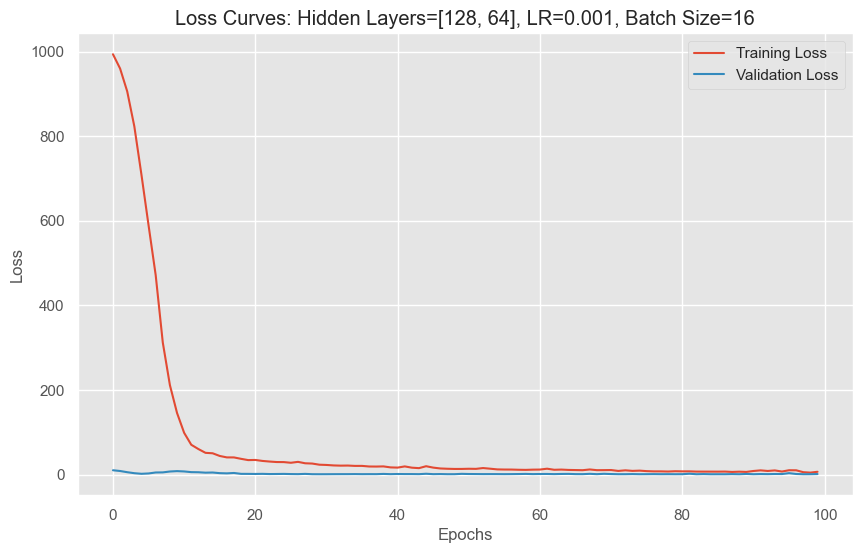

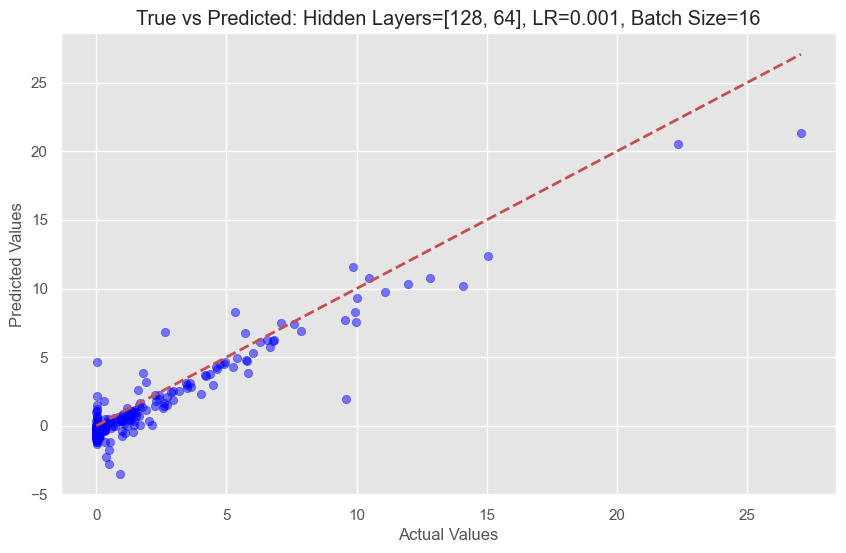


Training with hidden layers [128, 64], learning rate 0.001 and batch size 32...

Epoch 0/100, Training Loss: 948.3784423551776, Validation Loss: 9.729516127705574
Epoch 10/100, Training Loss: 355.75741677934474, Validation Loss: 4.725164747238159
Epoch 20/100, Training Loss: 44.23140734163198, Validation Loss: 4.171642649173736
Epoch 30/100, Training Loss: 58.12621780146252, Validation Loss: 1.8432275328785181
Epoch 40/100, Training Loss: 28.576099136336282, Validation Loss: 1.224302539229393
Epoch 50/100, Training Loss: 26.93245320970362, Validation Loss: 0.8366197191178799
Epoch 60/100, Training Loss: 19.771540452133525, Validation Loss: 0.8940826259553433
Epoch 70/100, Training Loss: 17.310169699517164, Validation Loss: 0.9759522259235383
Epoch 80/100, Training Loss: 14.475434872237118, Validation Loss: 1.3051490187644958
Epoch 90/100, Training Loss: 12.656980861317027, Validation Loss: 1.3547645598649978
R² Score: 0.8850


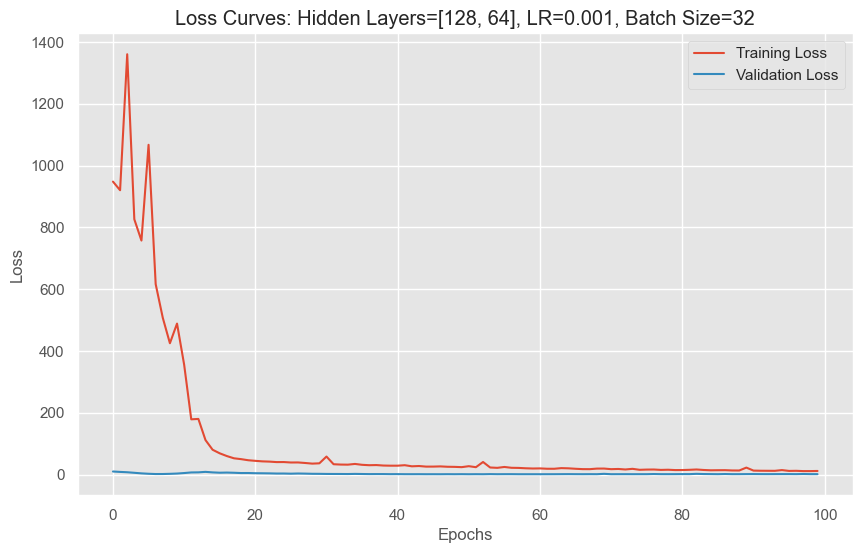

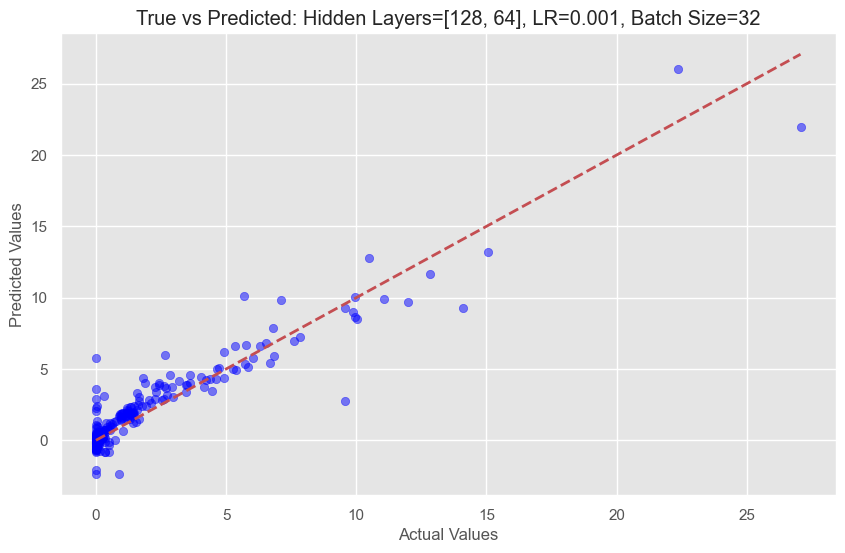


Training with hidden layers [128, 64], learning rate 0.001 and batch size 64...

Epoch 0/100, Training Loss: 970.9570045471191, Validation Loss: 11.687319898605347
Epoch 10/100, Training Loss: 564.1186265511947, Validation Loss: 1.509755277633667
Epoch 20/100, Training Loss: 74.73041712154041, Validation Loss: 6.578056383132934
Epoch 30/100, Training Loss: 41.85517758672888, Validation Loss: 1.9313462734222413
Epoch 40/100, Training Loss: 31.20191364396702, Validation Loss: 1.0486202239990234
Epoch 50/100, Training Loss: 25.995596538890492, Validation Loss: 1.0103558123111724
Epoch 60/100, Training Loss: 20.88369355960326, Validation Loss: 0.9893819034099579
Epoch 70/100, Training Loss: 17.73677731102163, Validation Loss: 0.9802517533302307
Epoch 80/100, Training Loss: 14.930263936519623, Validation Loss: 0.9867523908615112
Epoch 90/100, Training Loss: 12.843266145749526, Validation Loss: 0.9816339612007141
R² Score: 0.9095


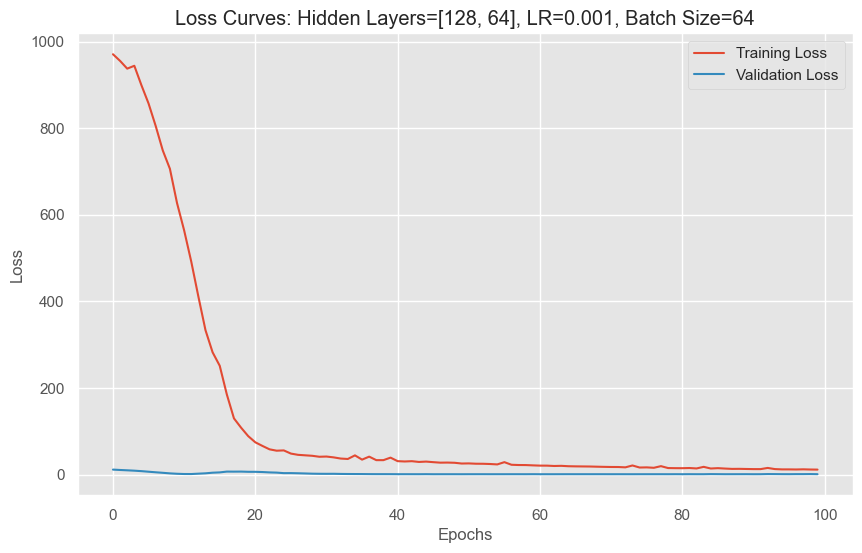

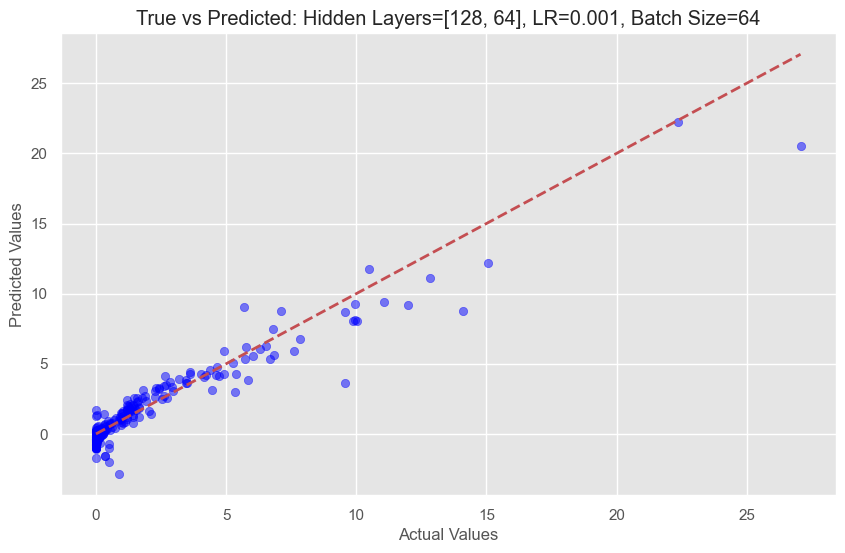


Training with hidden layers [128, 64, 32], learning rate 0.1 and batch size 8...

Epoch 0/100, Training Loss: 1299.8308130267055, Validation Loss: 14.684164190614545
Epoch 10/100, Training Loss: 918.4582248873749, Validation Loss: 1.551871582060247
Epoch 20/100, Training Loss: 889.5213943803033, Validation Loss: 13.000233391652236
Epoch 30/100, Training Loss: 746.5018819176354, Validation Loss: 10.524319767951965
Epoch 40/100, Training Loss: 687.3827077492551, Validation Loss: 19.783358225951325
Epoch 50/100, Training Loss: 663.0819261628528, Validation Loss: 24.198087937123066
Epoch 60/100, Training Loss: 626.2798871861468, Validation Loss: 21.543482840463923
Epoch 70/100, Training Loss: 594.6520334453603, Validation Loss: 23.804924449405156
Epoch 80/100, Training Loss: 572.1589775631247, Validation Loss: 54.2443496085502
Epoch 90/100, Training Loss: 547.7651036561922, Validation Loss: 10.429996719231477
R² Score: 0.4992


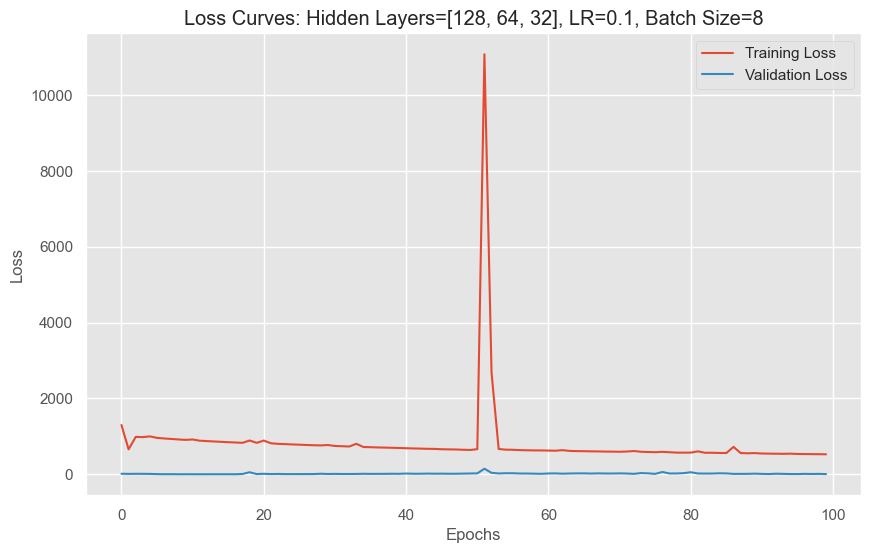

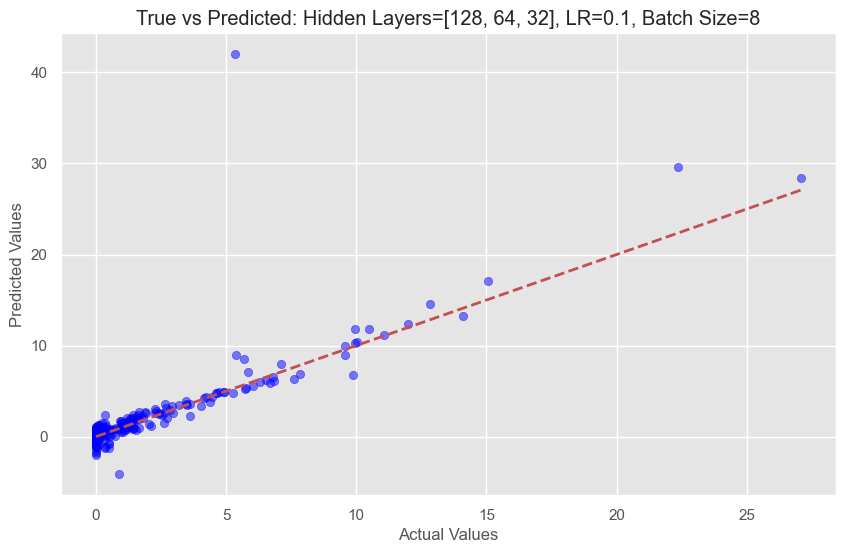


Training with hidden layers [128, 64, 32], learning rate 0.1 and batch size 16...

Epoch 0/100, Training Loss: 838.3401289596114, Validation Loss: 8.120264465087338
Epoch 10/100, Training Loss: 282.9654745722926, Validation Loss: 10.765297337582236
Epoch 20/100, Training Loss: 283.0039508897205, Validation Loss: 10.608344190999082
Epoch 30/100, Training Loss: 305.2830745674843, Validation Loss: 10.832973555514688
Epoch 40/100, Training Loss: 275.58877476426056, Validation Loss: 10.686500963411833
Epoch 50/100, Training Loss: 281.86460633056106, Validation Loss: 10.722139973389474
Epoch 60/100, Training Loss: 286.1745019458061, Validation Loss: 10.60750072880795
Epoch 70/100, Training Loss: 276.23998379707336, Validation Loss: 10.678194020923815
Epoch 80/100, Training Loss: 292.0585636260898, Validation Loss: 10.650737574225978
Epoch 90/100, Training Loss: 278.67410474045334, Validation Loss: 10.82688435755278
R² Score: -0.0202


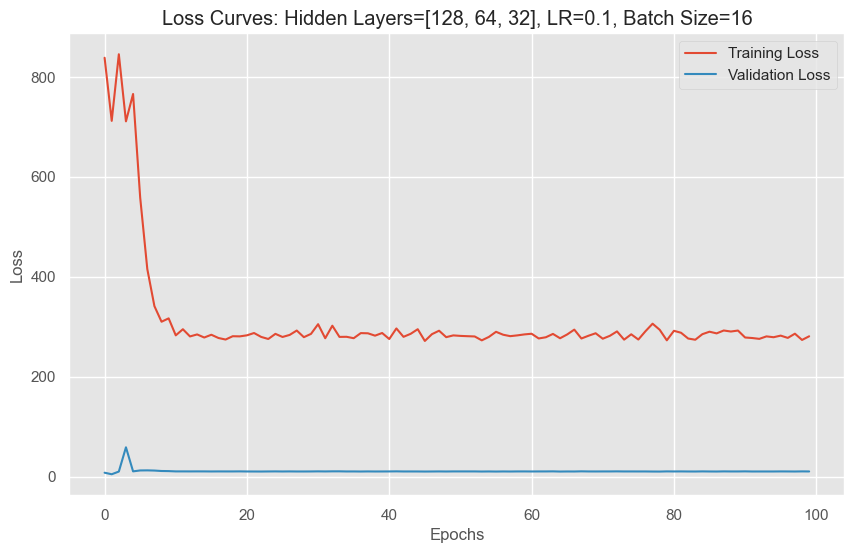

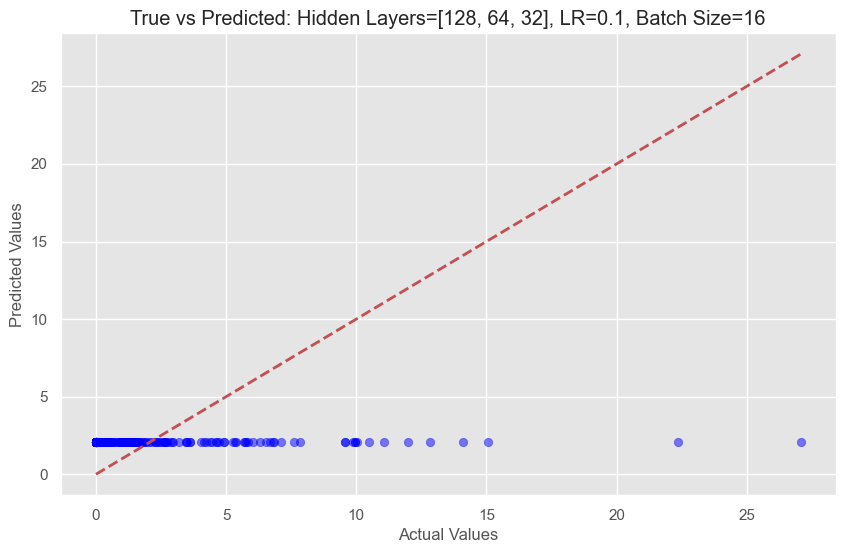


Training with hidden layers [128, 64, 32], learning rate 0.1 and batch size 32...

Epoch 0/100, Training Loss: 517.3051469759507, Validation Loss: 26.09173380881548
Epoch 10/100, Training Loss: 959.0244729302146, Validation Loss: 18.52312421798706
Epoch 20/100, Training Loss: 959.0018483942205, Validation Loss: 19.73899164199829
Epoch 30/100, Training Loss: 958.8234063495289, Validation Loss: 18.849552345275878
Epoch 40/100, Training Loss: 959.2841352115978, Validation Loss: 21.233307075500488
Epoch 50/100, Training Loss: 959.4309852773494, Validation Loss: 20.296679782867432
Epoch 60/100, Training Loss: 959.2791803533381, Validation Loss: 18.516811656951905
Epoch 70/100, Training Loss: 1050.1421660509977, Validation Loss: 18.856987285614014
Epoch 80/100, Training Loss: 958.8528213067489, Validation Loss: 20.974977111816408
Epoch 90/100, Training Loss: 959.1477544524453, Validation Loss: 20.107386302947997
R² Score: -0.7187


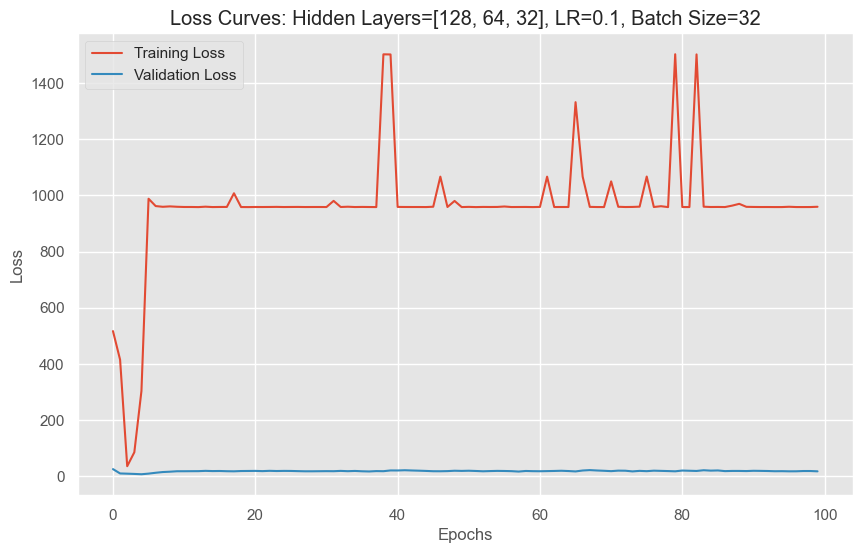

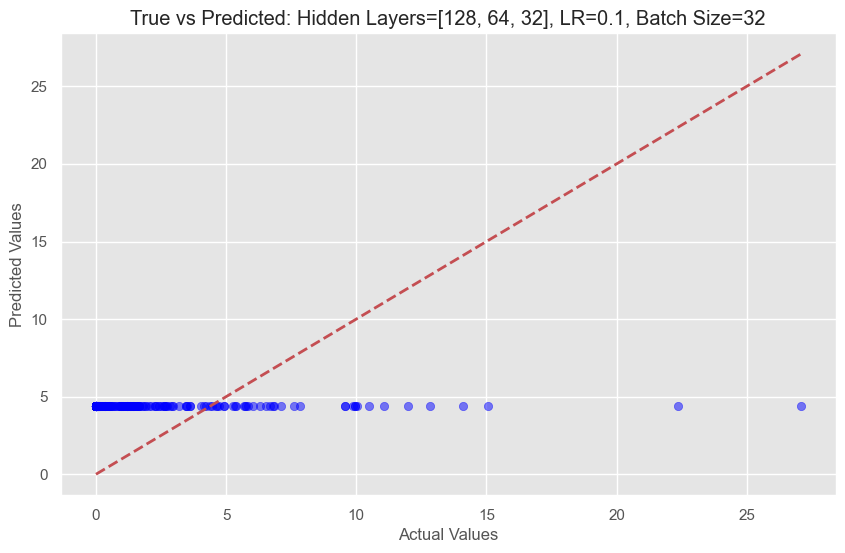


Training with hidden layers [128, 64, 32], learning rate 0.1 and batch size 64...

Epoch 0/100, Training Loss: 680.588720408353, Validation Loss: 151.06476135253905
Epoch 10/100, Training Loss: 959.2432612505826, Validation Loss: 16.075483322143555
Epoch 20/100, Training Loss: 958.9341897097501, Validation Loss: 19.674072265625
Epoch 30/100, Training Loss: 958.720723585649, Validation Loss: 19.303849029541016
Epoch 40/100, Training Loss: 1157.454299059781, Validation Loss: 18.767724990844727
Epoch 50/100, Training Loss: 960.2571024461226, Validation Loss: 19.09916114807129
Epoch 60/100, Training Loss: 960.2349224090576, Validation Loss: 19.600580978393555
Epoch 70/100, Training Loss: 1072.2723091298883, Validation Loss: 18.64772186279297
Epoch 80/100, Training Loss: 958.6469608653675, Validation Loss: 19.420143699645998
Epoch 90/100, Training Loss: 958.9514009302312, Validation Loss: 20.32502670288086
R² Score: -0.8858


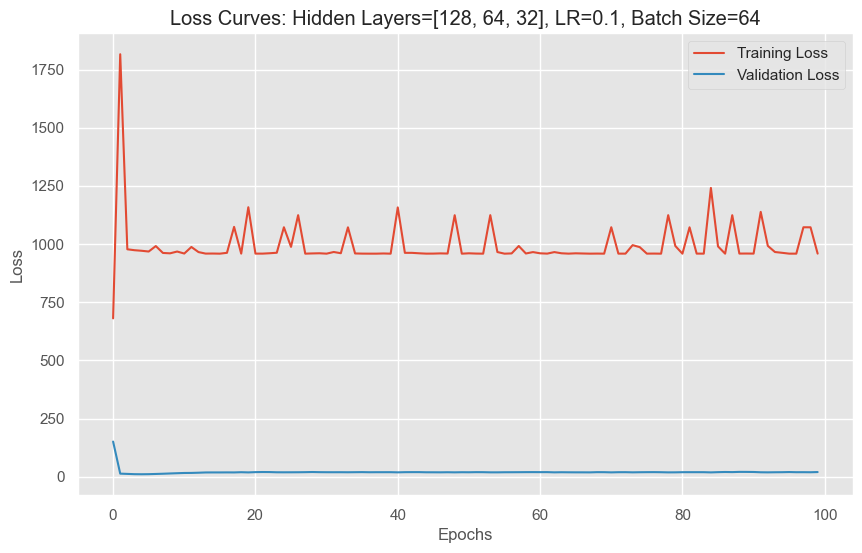

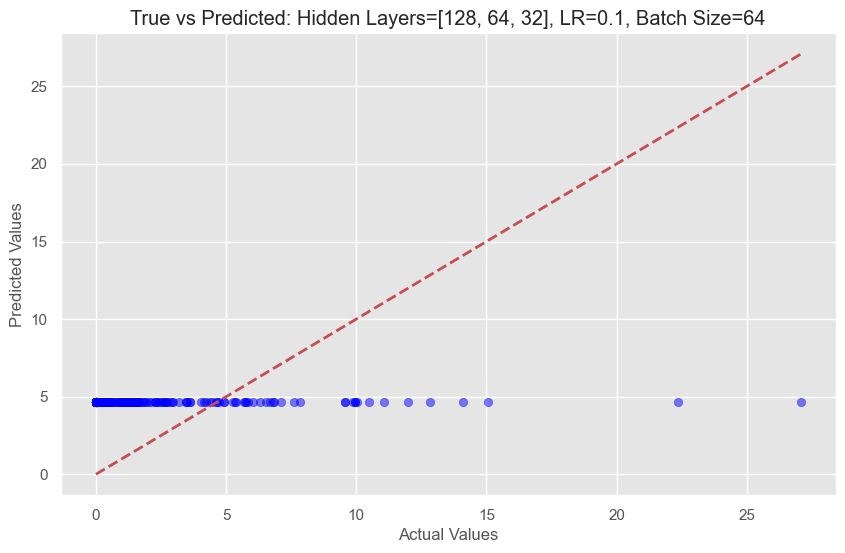


Training with hidden layers [128, 64, 32], learning rate 0.01 and batch size 8...

Epoch 0/100, Training Loss: 336.3802774468177, Validation Loss: 8.737073053379316
Epoch 10/100, Training Loss: 371.3779309482942, Validation Loss: 13.923498659520536
Epoch 20/100, Training Loss: 20.75422101415867, Validation Loss: 3.7213313696352213
Epoch 30/100, Training Loss: 10.304080501198769, Validation Loss: 1.7401629140650905
Epoch 40/100, Training Loss: 70.64855742463192, Validation Loss: 5.1643271558993575
Epoch 50/100, Training Loss: 10.641517100465853, Validation Loss: 0.8517428199584419
Epoch 60/100, Training Loss: 9.286904702352922, Validation Loss: 1.1227425853344235
Epoch 70/100, Training Loss: 4.856508768575136, Validation Loss: 1.0692969486117363
Epoch 80/100, Training Loss: 2.382054288546706, Validation Loss: 0.6144554304915506
Epoch 90/100, Training Loss: 30.044739302507665, Validation Loss: 1.2593449531374752
R² Score: 0.9173


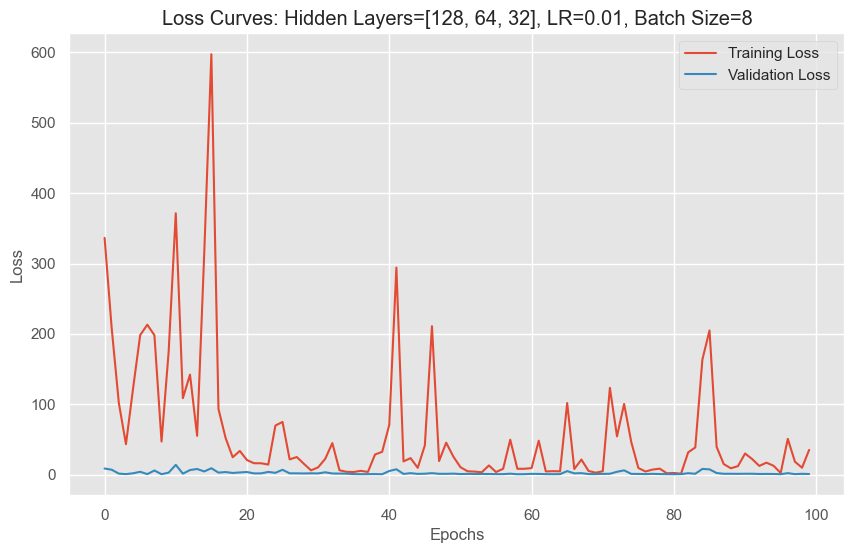

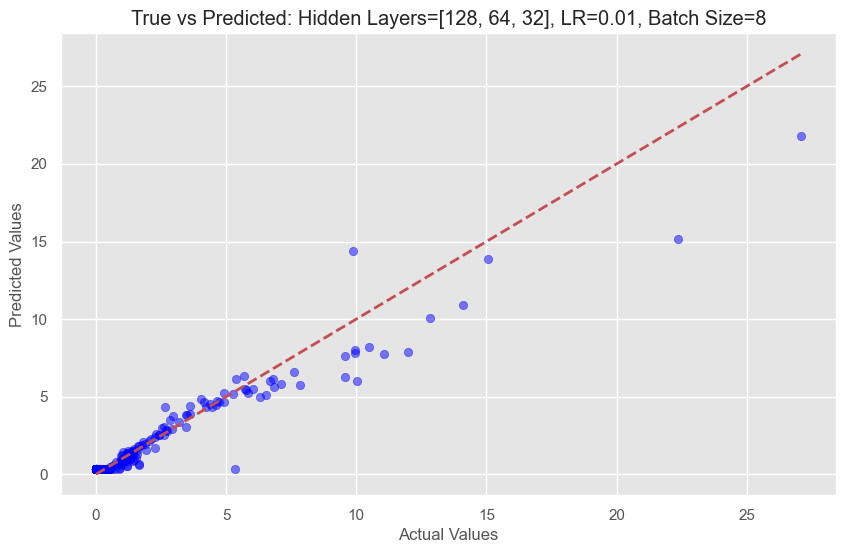


Training with hidden layers [128, 64, 32], learning rate 0.01 and batch size 16...

Epoch 0/100, Training Loss: 653.9560814472133, Validation Loss: 5.991520153848748
Epoch 10/100, Training Loss: 216.00296654812126, Validation Loss: 1.4601217633799504
Epoch 20/100, Training Loss: 9.150824081585851, Validation Loss: 1.1296720985127122
Epoch 30/100, Training Loss: 4.474285878414332, Validation Loss: 0.8823362018324827
Epoch 40/100, Training Loss: 106.647883647533, Validation Loss: 0.7366233875876979
Epoch 50/100, Training Loss: 6.013697728817893, Validation Loss: 0.5072256671264768
Epoch 60/100, Training Loss: 2.0608245763104667, Validation Loss: 0.4378955946303904
Epoch 70/100, Training Loss: 32.94597873449066, Validation Loss: 0.5047999299866589
Epoch 80/100, Training Loss: 23.6533494370578, Validation Loss: 0.6819369036116099
Epoch 90/100, Training Loss: 2.802863644934151, Validation Loss: 0.41710281695582363
R² Score: 0.9493


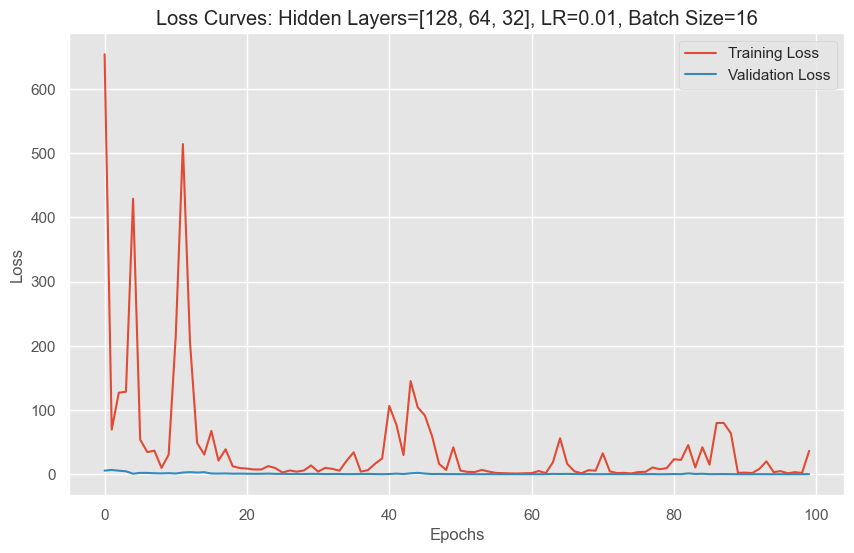

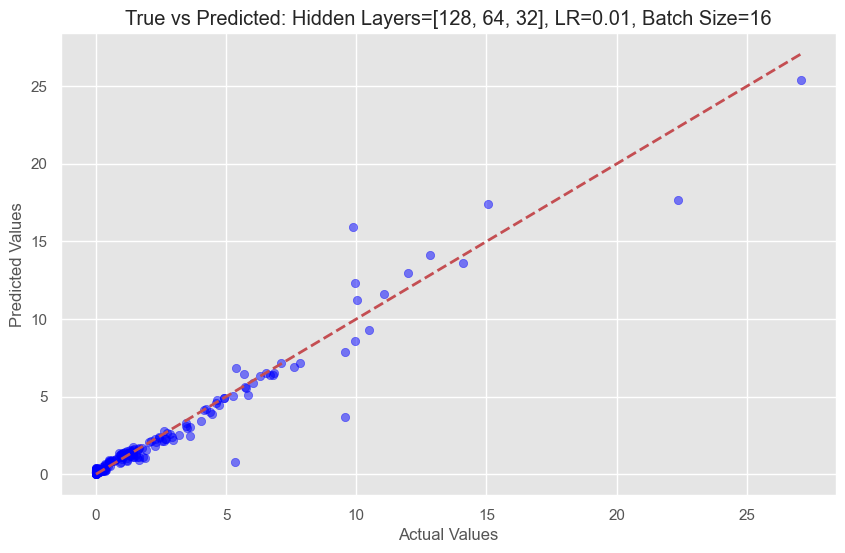


Training with hidden layers [128, 64, 32], learning rate 0.01 and batch size 32...

Epoch 0/100, Training Loss: 846.463668400591, Validation Loss: 1.6213797625154256
Epoch 10/100, Training Loss: 30.82023984566331, Validation Loss: 0.9951389020308852
Epoch 20/100, Training Loss: 6.548149911517447, Validation Loss: 1.032962166517973
Epoch 30/100, Training Loss: 32.32655119421807, Validation Loss: 1.0568384345620871
Epoch 40/100, Training Loss: 42.73018044030125, Validation Loss: 0.7337630638852716
Epoch 50/100, Training Loss: 1.1876238056204536, Validation Loss: 0.6105981791391969
Epoch 60/100, Training Loss: 117.55619825558229, Validation Loss: 0.6683138258755207
Epoch 70/100, Training Loss: 11.465969198129393, Validation Loss: 1.6367400497198106
Epoch 80/100, Training Loss: 1.754381144588644, Validation Loss: 0.9598665043711663
Epoch 90/100, Training Loss: 2.026637255468152, Validation Loss: 0.6521429501473903
R² Score: 0.9453


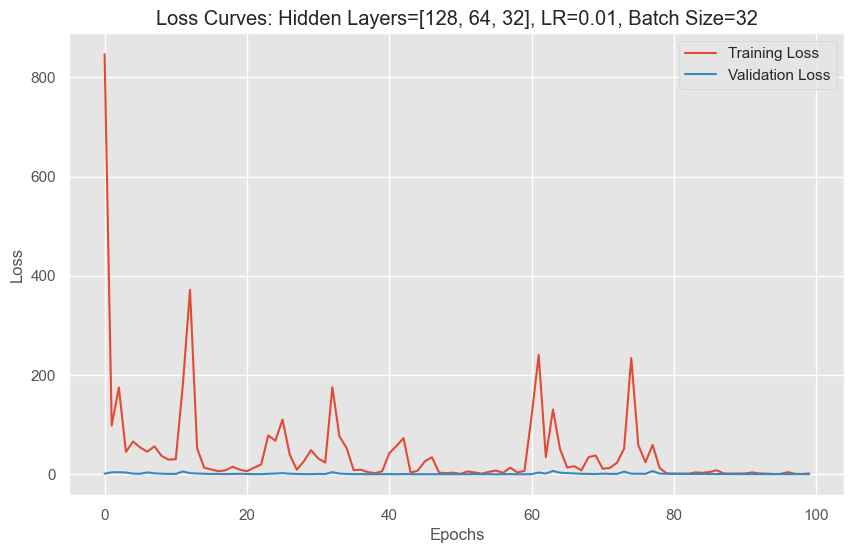

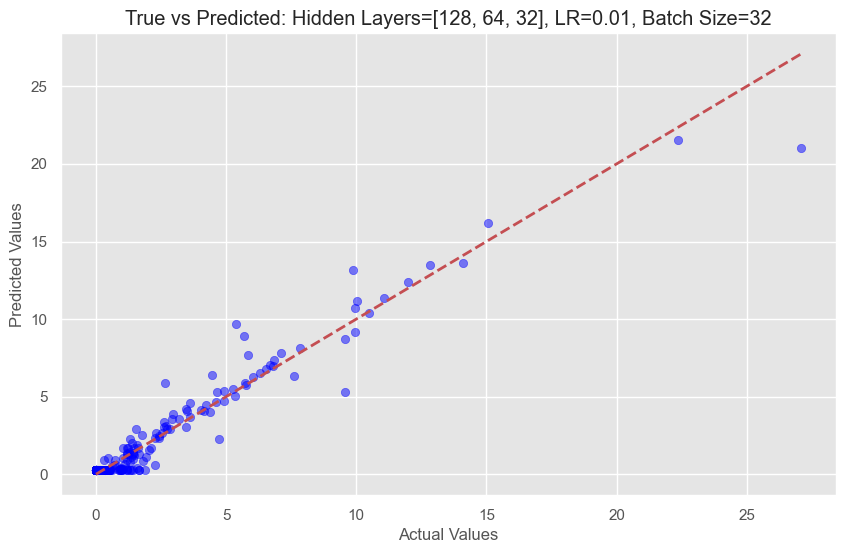


Training with hidden layers [128, 64, 32], learning rate 0.01 and batch size 64...

Epoch 0/100, Training Loss: 935.8795263983986, Validation Loss: 13.185058784484863
Epoch 10/100, Training Loss: 30.332151239568535, Validation Loss: 3.74838273525238
Epoch 20/100, Training Loss: 13.204959140582519, Validation Loss: 1.6446404576301574
Epoch 30/100, Training Loss: 15.300868822769685, Validation Loss: 1.1514083743095398
Epoch 40/100, Training Loss: 23.772313751957633, Validation Loss: 0.9226767420768738
Epoch 50/100, Training Loss: 25.016170507127587, Validation Loss: 0.7898481905460357
Epoch 60/100, Training Loss: 75.26614129814234, Validation Loss: 1.2841074347496033
Epoch 70/100, Training Loss: 1.9728428944945335, Validation Loss: 0.8678049445152283
Epoch 80/100, Training Loss: 16.02189050479369, Validation Loss: 0.7901090621948242
Epoch 90/100, Training Loss: 16.00594844601371, Validation Loss: 0.6217341184616089
R² Score: 0.9456


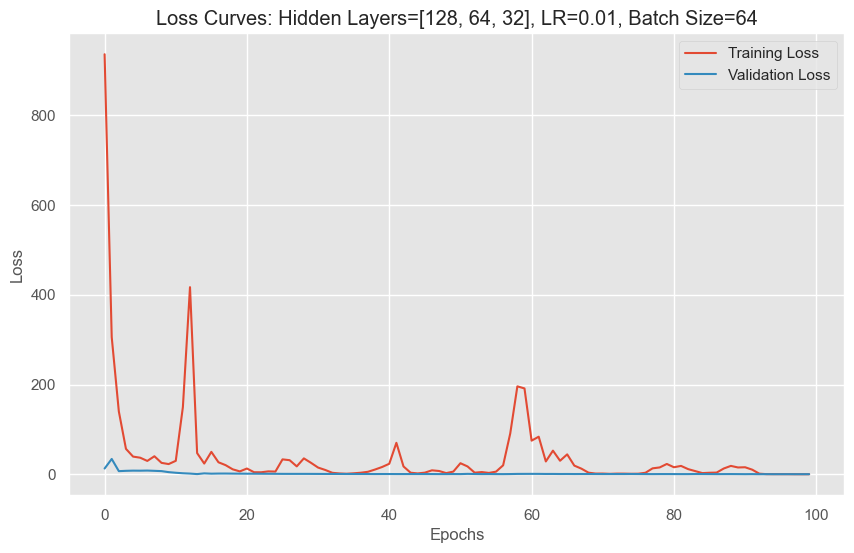

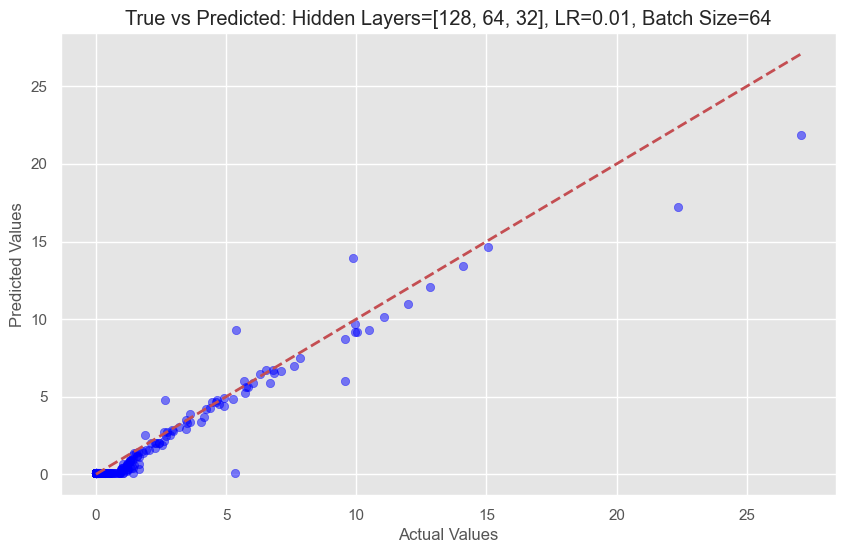


Training with hidden layers [128, 64, 32], learning rate 0.001 and batch size 8...

Epoch 0/100, Training Loss: 977.0143665993629, Validation Loss: 9.723223028956232
Epoch 10/100, Training Loss: 44.94602495403744, Validation Loss: 1.3460079053718899
Epoch 20/100, Training Loss: 32.24816484654019, Validation Loss: 0.3753502166553124
Epoch 30/100, Training Loss: 19.59342039606079, Validation Loss: 0.5358378967723331
Epoch 40/100, Training Loss: 9.728884528759261, Validation Loss: 0.3813388022417958
Epoch 50/100, Training Loss: 13.71857354081734, Validation Loss: 0.33279567710249813
Epoch 60/100, Training Loss: 8.81705914117764, Validation Loss: 0.262665741321807
Epoch 70/100, Training Loss: 8.705279931523512, Validation Loss: 0.31044505980822285
Epoch 80/100, Training Loss: 32.63709429417585, Validation Loss: 0.7166625221033354
Epoch 90/100, Training Loss: 6.129749784251501, Validation Loss: 0.3682226638775319
R² Score: 0.9749


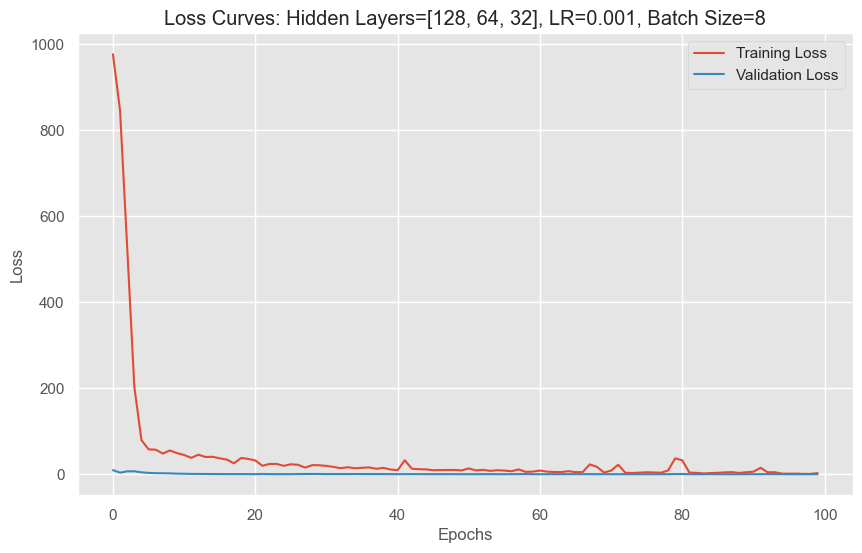

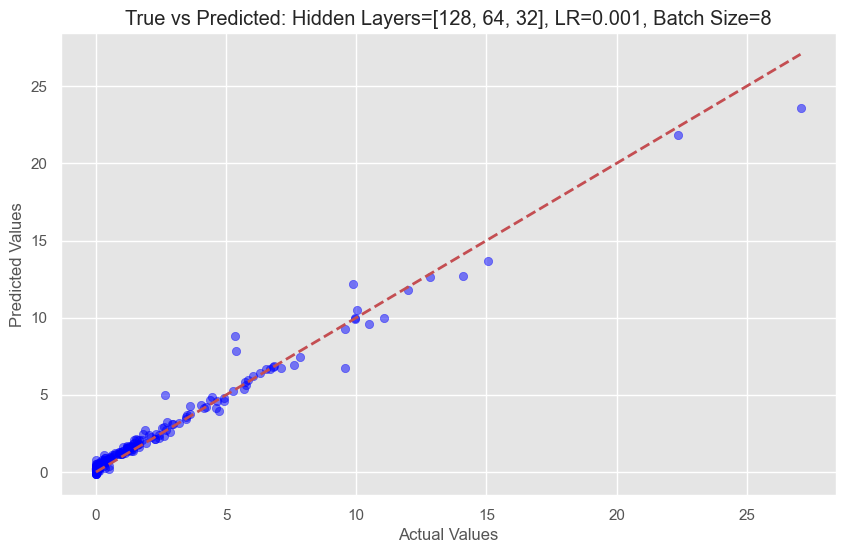


Training with hidden layers [128, 64, 32], learning rate 0.001 and batch size 16...

Epoch 0/100, Training Loss: 989.8755481343629, Validation Loss: 10.742292873169246
Epoch 10/100, Training Loss: 46.43641224850056, Validation Loss: 3.499429497279619
Epoch 20/100, Training Loss: 24.67880408942353, Validation Loss: 0.26675951774967344
Epoch 30/100, Training Loss: 14.322941576455568, Validation Loss: 0.6268941613992578
Epoch 40/100, Training Loss: 9.94428369021693, Validation Loss: 0.4094952966429685
Epoch 50/100, Training Loss: 7.882298003210751, Validation Loss: 0.39594816137105227
Epoch 60/100, Training Loss: 4.863850463701542, Validation Loss: 0.3704004481826958
Epoch 70/100, Training Loss: 2.997672863694471, Validation Loss: 0.3510871816328482
Epoch 80/100, Training Loss: 3.0970835312767777, Validation Loss: 0.4196758506525504
Epoch 90/100, Training Loss: 1.29158208800783, Validation Loss: 0.40950419685166134
R² Score: 0.9589


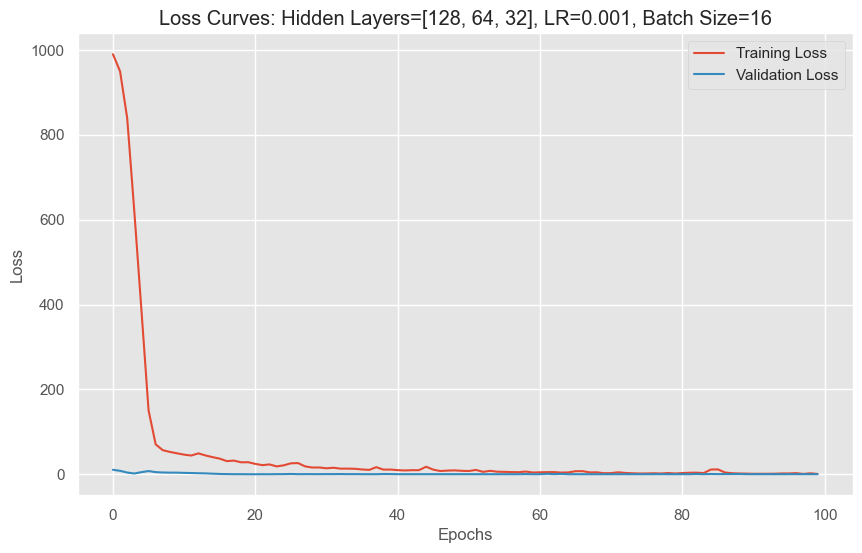

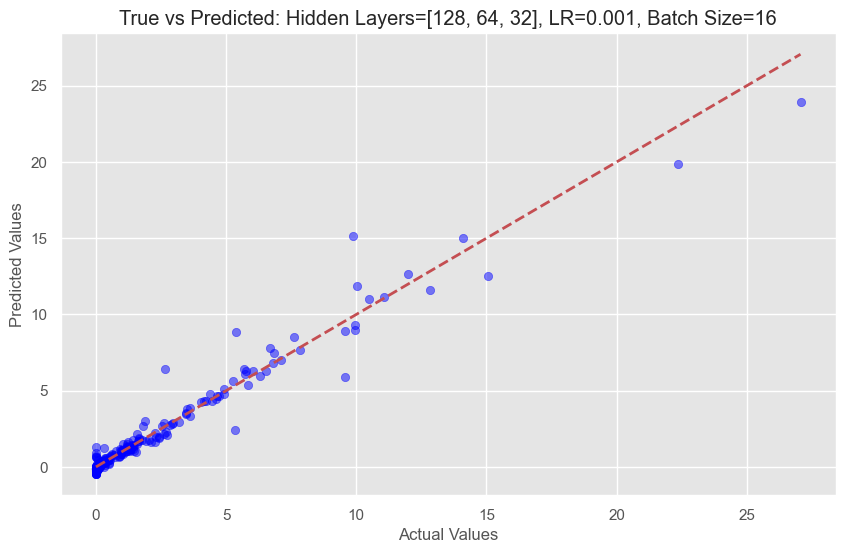


Training with hidden layers [128, 64, 32], learning rate 0.001 and batch size 32...

Epoch 0/100, Training Loss: 971.1075564731251, Validation Loss: 11.025723123550415
Epoch 10/100, Training Loss: 57.42755690217018, Validation Loss: 4.2057677283883095
Epoch 20/100, Training Loss: 36.50594650615346, Validation Loss: 1.6652439922094344
Epoch 30/100, Training Loss: 26.106624164364554, Validation Loss: 0.5899724449962378
Epoch 40/100, Training Loss: 36.085091818124056, Validation Loss: 0.3294024126604199
Epoch 50/100, Training Loss: 11.476685718548568, Validation Loss: 0.47449281103909013
Epoch 60/100, Training Loss: 8.780439913950183, Validation Loss: 0.5567993149161339
Epoch 70/100, Training Loss: 7.142428923059594, Validation Loss: 0.5038892073556781
Epoch 80/100, Training Loss: 5.3140558925541965, Validation Loss: 0.5013580286875368
Epoch 90/100, Training Loss: 3.493183696303855, Validation Loss: 0.4511988237500191
R² Score: 0.9591


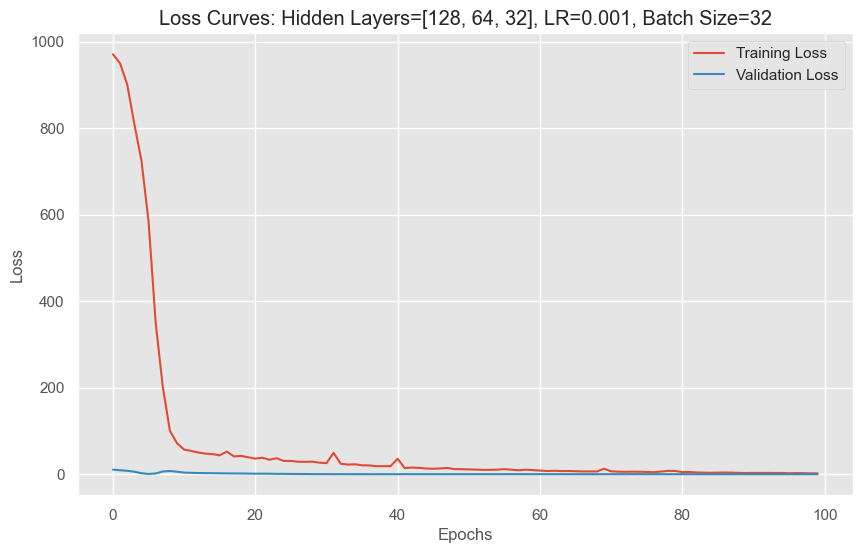

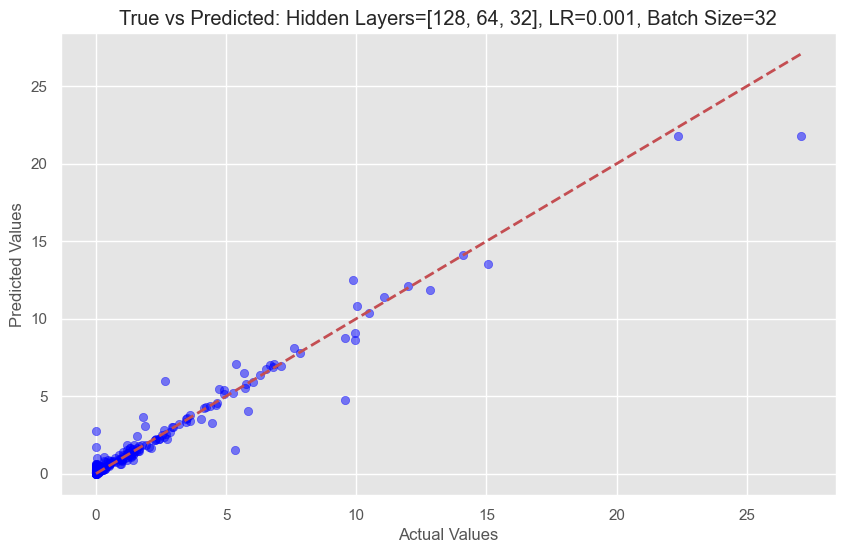


Training with hidden layers [128, 64, 32], learning rate 0.001 and batch size 64...

Epoch 0/100, Training Loss: 1005.2118269313465, Validation Loss: 11.855459928512573
Epoch 10/100, Training Loss: 279.42094966498286, Validation Loss: 3.811299133300781
Epoch 20/100, Training Loss: 41.484188654206015, Validation Loss: 3.380246615409851
Epoch 30/100, Training Loss: 31.82300440831618, Validation Loss: 1.8360729813575745
Epoch 40/100, Training Loss: 23.955757314508613, Validation Loss: 0.9184560537338257
Epoch 50/100, Training Loss: 16.933134425770152, Validation Loss: 1.0004571676254272
Epoch 60/100, Training Loss: 11.47062143615701, Validation Loss: 0.8460835933685302
Epoch 70/100, Training Loss: 9.329639306122607, Validation Loss: 0.673459655046463
Epoch 80/100, Training Loss: 6.557885142212564, Validation Loss: 0.5568772256374359
Epoch 90/100, Training Loss: 4.926911848512563, Validation Loss: 0.4770046412944794
R² Score: 0.9563


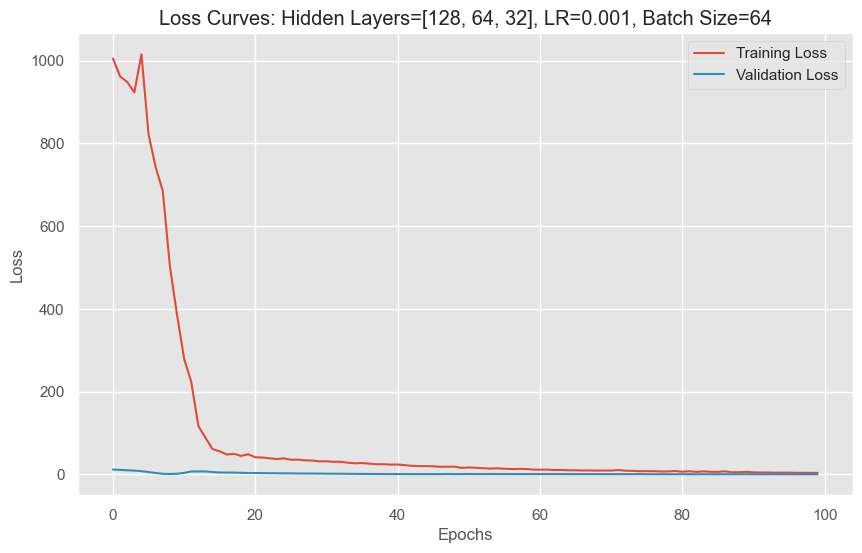

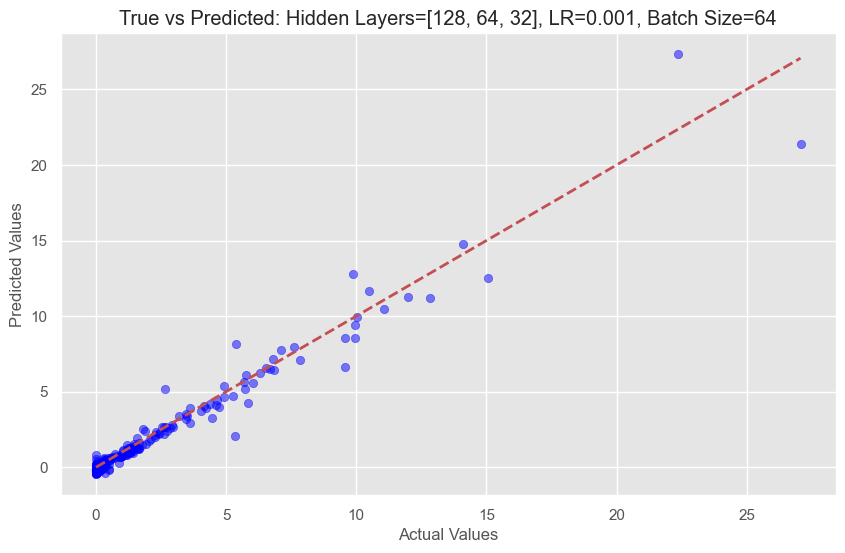


Best Model Configuration:
  Hidden Layers: [128, 64, 32]
  Learning Rate: 0.001
  Batch Size: 8
  Best R² Score: 0.9749


In [175]:
# Set hyperparameters (list of architectures, learning rates, and batch sizes to test)
hidden_layers_list = [
    [64],         # 1 hidden layer
    [128, 64],    # 2 hidden layers
    [128, 64, 32]  # 3 hidden layers (best candidate from earlier)
]
learning_rates = [0.1, 0.01, 0.001]  # Learning rates to try
batch_sizes = [8, 16, 32, 64]  # Batch sizes to try
epochs = 100  # Number of epochs

# Run the experiment
run_optimized_experiment(hidden_layers_list, learning_rates, batch_sizes, epochs)
